In [1]:
# JUPYTER CELL 1 — Imports
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Diabetes Prediction Dataset

In [2]:
# JUPYTER CELL 2 — Load dataset & preprocess (numeric-only → impute → scale)
DATA_PATH = Path("diabetes_prediction_dataset.csv")  # <-- change this if needed
df = pd.read_csv(DATA_PATH)

# numeric-only (KMeans needs numeric features)
X = df.select_dtypes(include=[np.number]).copy()
# drop constants (if any)
X = X.loc[:, X.nunique(dropna=False) > 1]

pre = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler",  StandardScaler()),
])

Xs = pre.fit_transform(X)
Xs.shape

(100000, 7)

In [3]:
# JUPYTER CELL 3 — PCA(2) and PCA(3) for modeling / visualization
pca2 = PCA(n_components=2, random_state=42).fit(Xs)
Z2   = pca2.transform(Xs)

pca3 = PCA(n_components=3, random_state=42).fit(Xs)
Z3   = pca3.transform(Xs)

print("Explained variance (2 PCs):", pca2.explained_variance_ratio_)
print("Explained variance (3 PCs):", pca3.explained_variance_ratio_)

Explained variance (2 PCs): [0.30133365 0.16985723]
Explained variance (3 PCs): [0.30133365 0.16985723 0.13471366]


In [4]:
# JUPYTER CELL 4 — choose K by Silhouette and fit KMeans++
def fit_kmeans_best(Z, k_list=(2,3,4,5), random_state=42, sample_for_sil=20000):
    # Optionally subsample for silhouette to speed up on very large n
    n = Z.shape[0]
    if n > sample_for_sil:
        rng = np.random.default_rng(random_state)
        idx = rng.choice(n, size=sample_for_sil, replace=False)
        Z_sil = Z[idx]
    else:
        Z_sil = Z

    rows = []
    best_score, best_model = -1, None

    for k in k_list:
        km = KMeans(n_clusters=k, init="k-means++", n_init=10, random_state=random_state)
        labels = km.fit_predict(Z)
        sil = silhouette_score(Z_sil, km.predict(Z_sil))  # evaluate on (sub)sample
        rows.append({"k": k, "silhouette": sil, "inertia": km.inertia_})
        if sil > best_score:
            best_score, best_model = sil, km

    metrics = pd.DataFrame(rows).sort_values("k").reset_index(drop=True)
    return best_model, metrics

km2, metrics2 = fit_kmeans_best(Z2)
km3, metrics3 = fit_kmeans_best(Z3)

print("Best K (2D PCA):", km2.n_clusters, "\n", metrics2)
print("\nBest K (3D PCA):", km3.n_clusters, "\n", metrics3)

C:\Users\Omistaja\anaconda3\Anaconda\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\Omistaja\anaconda3\Anaconda\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\Omistaja\anaconda3\Anaconda\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Omistaja\anaconda3\Anaconda\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\Omistaja\anaconda3\Anaconda\Lib\subprocess.py", line 1538

Best K (2D PCA): 2 
    k  silhouette        inertia
0  2    0.614799  189653.374542
1  3    0.375502  119735.937882
2  4    0.371704   90360.966369
3  5    0.369230   71839.019876

Best K (3D PCA): 3 
    k  silhouette        inertia
0  2    0.583230  280647.000431
1  3    0.599042  207365.332746
2  4    0.354997  138729.182509
3  5    0.320439  115829.502146


In [6]:
# JUPYTER CELL 5 — report clustering metrics for chosen K
def report_metrics(Z, labels):
    return {
        "silhouette": silhouette_score(Z, labels),
        "calinski_harabasz": calinski_harabasz_score(Z, labels),
        "davies_bouldin": davies_bouldin_score(Z, labels),
    }

m2 = report_metrics(Z2, km2.labels_)
m3 = report_metrics(Z3, km3.labels_)

print("2D PCA metrics:", m2)
print("3D PCA metrics:", m3)

# Cluster sizes
print("\n2D cluster sizes:\n", pd.Series(km2.labels_).value_counts().sort_index())
print("\n3D cluster sizes:\n", pd.Series(km3.labels_).value_counts().sort_index())

2D PCA metrics: {'silhouette': 0.613943259970089, 'calinski_harabasz': 73912.60095146963, 'davies_bouldin': 0.7025846601801277}
3D PCA metrics: {'silhouette': 0.5974777132376443, 'calinski_harabasz': 52265.57357276991, 'davies_bouldin': 0.6638813156202216}

2D cluster sizes:
 0     9642
1    90358
Name: count, dtype: int64

3D cluster sizes:
 0    88524
1     7556
2     3920
Name: count, dtype: int64


C:\Users\Omistaja\AppData\Local\Temp\ipykernel_3192\2560498396.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab10", km2.n_clusters)


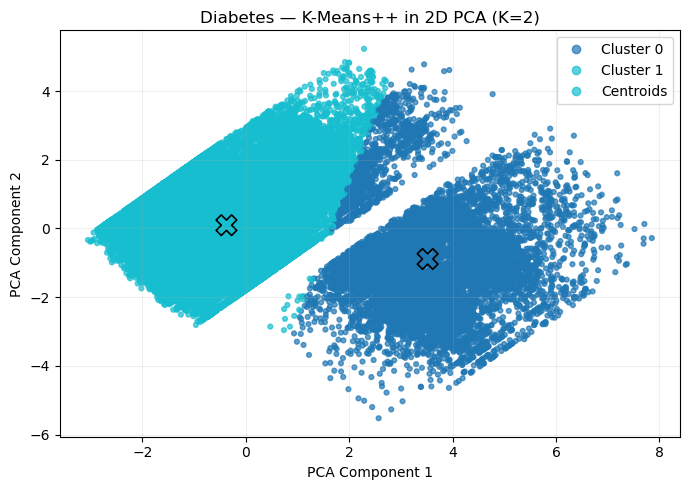

In [7]:
# JUPYTER CELL 6 — 2D plot (PCA components 1 & 2)
plt.figure(figsize=(7,5))
# consistent discrete colors
cmap = plt.cm.get_cmap("tab10", km2.n_clusters)
sc = plt.scatter(Z2[:,0], Z2[:,1], s=12, alpha=0.7, c=km2.labels_, cmap=cmap)

# centroids (transform cluster centers are in PCA space already)
centroids2 = km2.cluster_centers_
plt.scatter(centroids2[:,0], centroids2[:,1],
            s=220, marker='X', edgecolor='black', linewidths=1.2, facecolor='none', label="Centroids")

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title(f"Diabetes — K-Means++ in 2D PCA (K={km2.n_clusters})")

# legend for clusters + centroids
handles, labels = sc.legend_elements(num=km2.n_clusters)
plt.legend(handles + [plt.Line2D([], [], marker='X', linestyle='None', markersize=10,
                                 markeredgecolor='black', markerfacecolor='none', label='Centroids')],
           [f"Cluster {i}" for i in range(km2.n_clusters)] + ["Centroids"],
           loc="best", frameon=True)

plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()

C:\Users\Omistaja\AppData\Local\Temp\ipykernel_3192\2660341091.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab10", km2.n_clusters)


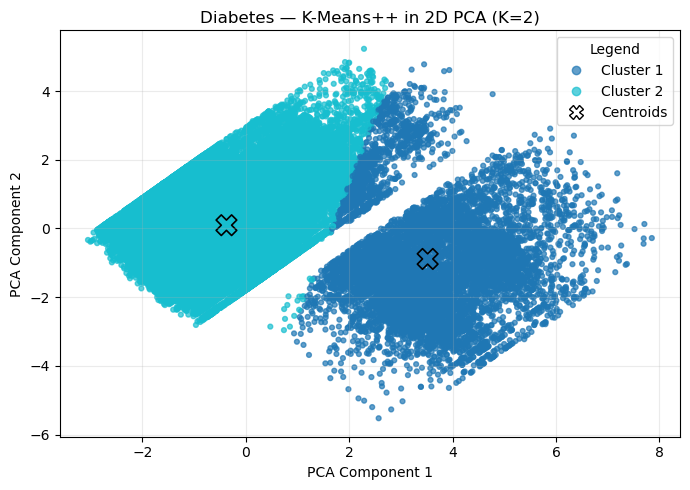

In [9]:
# JUPYTER CELL — Improved legend (Cluster 1/2 + Centroids label)
plt.figure(figsize=(7,5))
cmap = plt.cm.get_cmap("tab10", km2.n_clusters)

# Scatter plot of data points
sc = plt.scatter(Z2[:,0], Z2[:,1], s=12, alpha=0.7, c=km2.labels_, cmap=cmap)

# Plot centroids
centroids2 = km2.cluster_centers_
plt.scatter(centroids2[:,0], centroids2[:,1],
            s=220, marker='X', edgecolor='black', linewidths=1.2,
            facecolor='none', label="Centroids")

# Labels & title
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title(f"Diabetes — K-Means++ in 2D PCA (K={km2.n_clusters})")

# Build cluster legend with nicer names
cluster_handles, _ = sc.legend_elements()
cluster_labels = [f"Cluster {i+1}" for i in range(km2.n_clusters)]

# Combine cluster legend + centroid legend
plt.legend(cluster_handles + [plt.Line2D([], [], marker='X', linestyle='None', markersize=10,
                                         markeredgecolor='black', markerfacecolor='none')],
           cluster_labels + ["Centroids"],
           title="Legend",
           loc="best", frameon=True)

plt.grid(True, alpha=0.25)
plt.tight_layout()
plt.show()


C:\Users\Omistaja\AppData\Local\Temp\ipykernel_3192\3208149792.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap3 = plt.cm.get_cmap("tab10", km3.n_clusters)


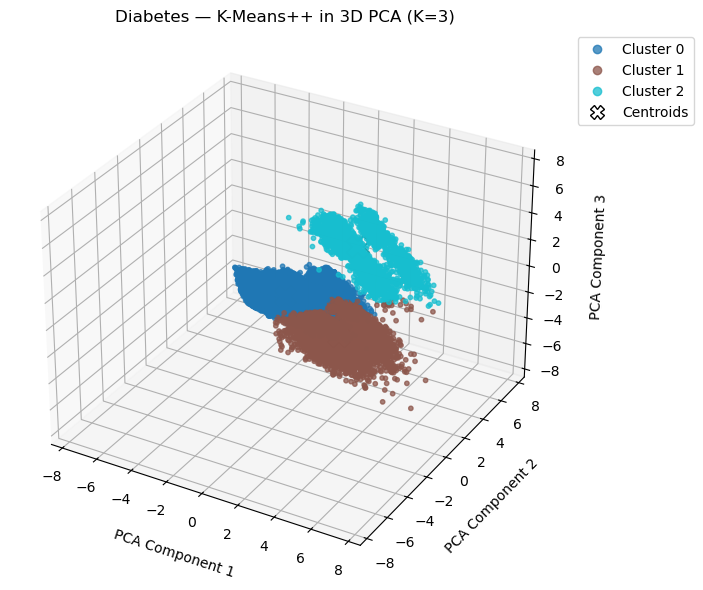

In [8]:
# JUPYTER CELL 7 — 3D plot (PCA components 1–3)
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

cmap3 = plt.cm.get_cmap("tab10", km3.n_clusters)
sc3 = ax.scatter(Z3[:,0], Z3[:,1], Z3[:,2],
                 s=10, alpha=0.75, c=km3.labels_, cmap=cmap3)

centroids3 = km3.cluster_centers_
ax.scatter(centroids3[:,0], centroids3[:,1], centroids3[:,2],
           s=260, marker='X', edgecolor='black', linewidths=1.2, facecolor='none', label="Centroids")

ax.set_xlabel("PCA Component 1", labelpad=10)
ax.set_ylabel("PCA Component 2", labelpad=10)
ax.set_zlabel("PCA Component 3", labelpad=10)
ax.set_title(f"Diabetes — K-Means++ in 3D PCA (K={km3.n_clusters})")

# shared legend
handles, labels = sc3.legend_elements(num=km3.n_clusters)
legend = ax.legend(handles + [plt.Line2D([], [], marker='X', linestyle='None', markersize=10,
                                         markeredgecolor='black', markerfacecolor='none', label='Centroids')],
                   [f"Cluster {i}" for i in range(km3.n_clusters)] + ["Centroids"],
                   loc="upper left", bbox_to_anchor=(1.02, 1.0), frameon=True)

# keep data within view & avoid clipping
lim = np.max(np.abs(Z3[:,:3])) * 1.1
ax.set_xlim(-lim, lim); ax.set_ylim(-lim, lim); ax.set_zlim(-lim, lim)

plt.tight_layout()
plt.show()

C:\Users\Omistaja\AppData\Local\Temp\ipykernel_3192\942389542.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap3 = plt.cm.get_cmap("tab10", km3.n_clusters)


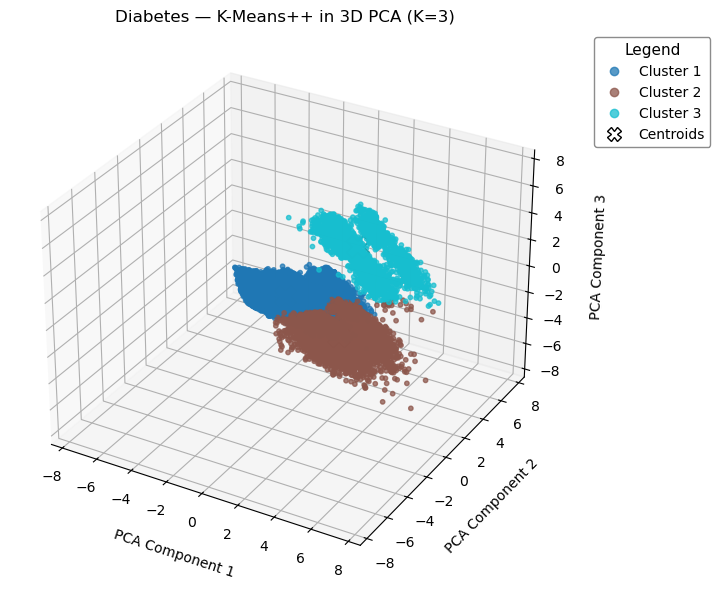

In [10]:
# JUPYTER CELL — 3D PCA plot with clean legend (Cluster 1,2,3 + Centroids)
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

cmap3 = plt.cm.get_cmap("tab10", km3.n_clusters)
sc3 = ax.scatter(Z3[:,0], Z3[:,1], Z3[:,2],
                 s=10, alpha=0.75, c=km3.labels_, cmap=cmap3)

# Centroids
centroids3 = km3.cluster_centers_
ax.scatter(centroids3[:,0], centroids3[:,1], centroids3[:,2],
           s=260, marker='X', edgecolor='black', linewidths=1.2,
           facecolor='none', label="Centroids")

# Labels & title
ax.set_xlabel("PCA Component 1", labelpad=10)
ax.set_ylabel("PCA Component 2", labelpad=10)
ax.set_zlabel("PCA Component 3", labelpad=10)
ax.set_title(f"Diabetes — K-Means++ in 3D PCA (K={km3.n_clusters})")

# ----- Improved legend -----
cluster_handles, _ = sc3.legend_elements()
cluster_labels = [f"Cluster {i+1}" for i in range(km3.n_clusters)]

legend = ax.legend(cluster_handles + [plt.Line2D([], [], marker='X', linestyle='None', markersize=10,
                                                 markeredgecolor='black', markerfacecolor='none')],
                   cluster_labels + ["Centroids"],
                   title="Legend",
                   loc="upper left", bbox_to_anchor=(1.05, 1.0),
                   frameon=True, fontsize=10, title_fontsize=11)

legend.get_frame().set_alpha(0.9)
legend.get_frame().set_edgecolor("gray")

# Keep axes balanced
lim = np.max(np.abs(Z3[:,:3])) * 1.1
ax.set_xlim(-lim, lim); ax.set_ylim(-lim, lim); ax.set_zlim(-lim, lim)

plt.tight_layout()
plt.show()

## Euclidean

In [2]:
import matplotlib.colors as mcolors

In [12]:
# JUPYTER CELL 2 — load & preprocess
DATA_PATH = Path("diabetes_prediction_dataset.csv")  # change if using another file
df = pd.read_csv(DATA_PATH)

# numeric-only for KMeans
X = df.select_dtypes(include=[np.number]).copy()
# remove constant columns
X = X.loc[:, X.nunique(dropna=False) > 1]

pre = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler",  StandardScaler()),
])
Xs = pre.fit_transform(X)

print("Data shape after preprocessing:", Xs.shape)

Data shape after preprocessing: (100000, 7)


In [13]:
# JUPYTER CELL 3 — PCA(3)
pca = PCA(n_components=3, random_state=42).fit(Xs)
Z3  = pca.transform(Xs)     # 3D coordinates for plotting or for "PCA-before" clustering
print("Explained variance ratio (3 PCs):", pca.explained_variance_ratio_)

Explained variance ratio (3 PCs): [0.30133365 0.16985723 0.13471366]


In [14]:
# JUPYTER CELL 4 — KMeans++ (Euclidean) before vs after PCA
K = 3  # choose the number of clusters you want to show

# (a) Reduce dimension BEFORE clustering
km_before = KMeans(n_clusters=K, init="k-means++", n_init=10, random_state=42)
labels_before = km_before.fit_predict(Z3)                   # cluster in 3D PCA space
centroids_before_pca = km_before.cluster_centers_           # already in PCA space

# (b) Reduce dimension AFTER clustering
km_after = KMeans(n_clusters=K, init="k-means++", n_init=10, random_state=42)
labels_after = km_after.fit_predict(Xs)                     # cluster in full scaled space (Euclidean)
centroids_after_pca = pca.transform(km_after.cluster_centers_)  # project centroids to PCA space

# quick sanity: silhouettes (optional)
sil_before = silhouette_score(Z3, labels_before, sample_size=min(10000, len(Z3)), random_state=42)
sil_after  = silhouette_score(Z3, labels_after,  sample_size=min(10000, len(Z3)), random_state=42)
print(f"Silhouette (PCA→KMeans): {sil_before:.3f}  |  Silhouette (KMeans→PCA): {sil_after:.3f}")

Silhouette (PCA→KMeans): 0.599  |  Silhouette (KMeans→PCA): 0.601


In [15]:
# JUPYTER CELL 5 — color mapping helpers
def discrete_viridis(K):
    # a discrete version of viridis with K distinct colors
    cmap = plt.cm.get_cmap("viridis", K)
    norm = mcolors.BoundaryNorm(boundaries=np.arange(-0.5, K + 0.5, 1), ncolors=K)
    ticks = np.arange(K)
    ticklabels = [f"Cluster {i+1}" for i in range(K)]
    return cmap, norm, ticks, ticklabels

C:\Users\Omistaja\AppData\Local\Temp\ipykernel_3192\2851068314.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("viridis", K)


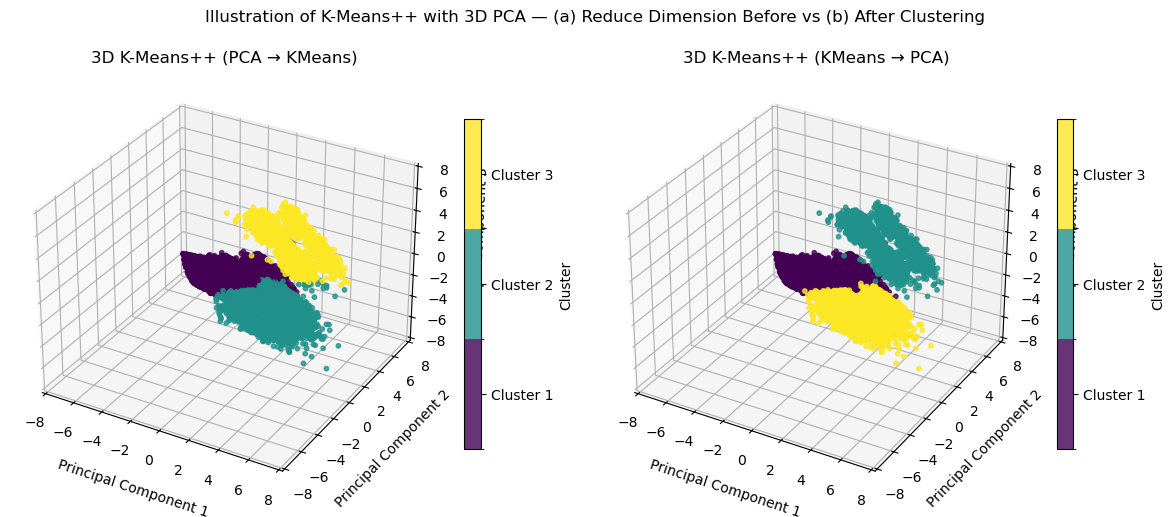

In [16]:
# JUPYTER CELL 6 — side-by-side 3D plots with viridis + centroids
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

cmap, norm, ticks, ticklabels = discrete_viridis(K)

fig = plt.figure(figsize=(12,5))

# ---------- (a) PCA before clustering ----------
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
sc1 = ax1.scatter(Z3[:,0], Z3[:,1], Z3[:,2],
                  s=10, alpha=0.8, c=labels_before, cmap=cmap, norm=norm)
ax1.scatter(centroids_before_pca[:,0], centroids_before_pca[:,1], centroids_before_pca[:,2],
            s=260, marker='X', edgecolor='black', linewidths=1.2, facecolor='none')
ax1.set_title("3D K-Means++ (PCA → KMeans)")
ax1.set_xlabel("Principal Component 1", labelpad=8)
ax1.set_ylabel("Principal Component 2", labelpad=8)
ax1.set_zlabel("Principal Component 3", labelpad=8)
lim = np.max(np.abs(Z3)) * 1.05
ax1.set_xlim(-lim, lim); ax1.set_ylim(-lim, lim); ax1.set_zlim(-lim, lim)
cbar1 = fig.colorbar(sc1, ax=ax1, shrink=0.75, pad=0.05)
cbar1.set_ticks(ticks); cbar1.set_ticklabels(ticklabels); cbar1.set_label("Cluster")

# ---------- (b) PCA after clustering ----------
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
sc2 = ax2.scatter(Z3[:,0], Z3[:,1], Z3[:,2],
                  s=10, alpha=0.8, c=labels_after, cmap=cmap, norm=norm)
ax2.scatter(centroids_after_pca[:,0], centroids_after_pca[:,1], centroids_after_pca[:,2],
            s=260, marker='X', edgecolor='black', linewidths=1.2, facecolor='none')
ax2.set_title("3D K-Means++ (KMeans → PCA)")
ax2.set_xlabel("Principal Component 1", labelpad=8)
ax2.set_ylabel("Principal Component 2", labelpad=8)
ax2.set_zlabel("Principal Component 3", labelpad=8)
ax2.set_xlim(-lim, lim); ax2.set_ylim(-lim, lim); ax2.set_zlim(-lim, lim)
cbar2 = fig.colorbar(sc2, ax=ax2, shrink=0.75, pad=0.05)
cbar2.set_ticks(ticks); cbar2.set_ticklabels(ticklabels); cbar2.set_label("Cluster")

plt.suptitle("Illustration of K-Means++ with 3D PCA — (a) Reduce Dimension Before vs (b) After Clustering", y=1.02)
plt.tight_layout()
plt.show()

C:\Users\Omistaja\AppData\Local\Temp\ipykernel_3192\1618328296.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("viridis", K)


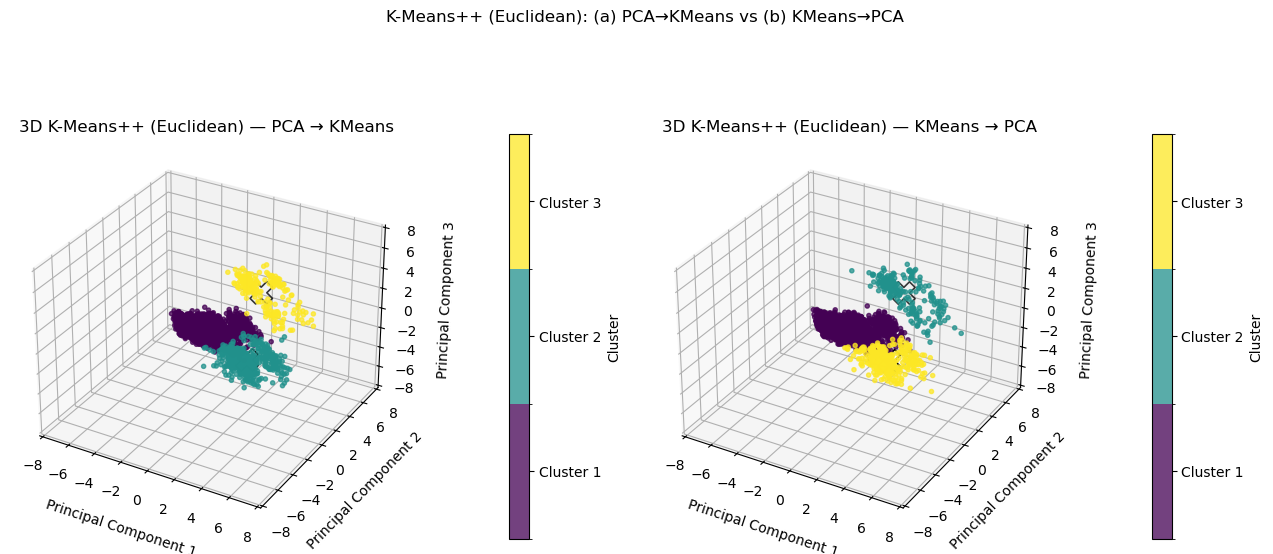

In [22]:
# --- CONFIG ---
K = 3                 # number of clusters to show
N_SHOW = 6000         # max points to plot per panel (set None to show all)
RANDOM_STATE = 42

# --- Discrete viridis for K clusters (same palette you used) ---
import matplotlib.colors as mcolors
def discrete_viridis(K):
    cmap = plt.cm.get_cmap("viridis", K)
    norm = mcolors.BoundaryNorm(boundaries=np.arange(-0.5, K+0.5, 1), ncolors=K)
    ticks = np.arange(K)
    ticklabels = [f"Cluster {i+1}" for i in range(K)]
    return cmap, norm, ticks, ticklabels

cmap, norm, ticks, ticklabels = discrete_viridis(K)

# --- 1) PCA(3) once (for panel a plotting and for panel b projection) ---
pca_eu = PCA(n_components=3, random_state=RANDOM_STATE).fit(Xs)
Z3_eu   = pca_eu.transform(Xs)   # 3D coords

# --- 2) (a) Reduce dimension BEFORE clustering (Euclidean by default) ---
km_before_eu = KMeans(n_clusters=K, init="k-means++", n_init=10, random_state=RANDOM_STATE)
labels_before_eu = km_before_eu.fit_predict(Z3_eu)
centroids_before_pca_eu = km_before_eu.cluster_centers_   # already in PCA space

# --- 3) (b) Reduce dimension AFTER clustering (fit on full scaled space, then project) ---
km_after_eu = KMeans(n_clusters=K, init="k-means++", n_init=10, random_state=RANDOM_STATE)
labels_after_eu = km_after_eu.fit_predict(Xs)
centroids_after_pca_eu = pca_eu.transform(km_after_eu.cluster_centers_)

# --- 4) Optional subsampling for clearer visuals ---
rng = np.random.default_rng(RANDOM_STATE)
if N_SHOW is not None and N_SHOW < len(Z3_eu):
    idx_a = rng.choice(len(Z3_eu), N_SHOW, replace=False)
    idx_b = rng.choice(len(Z3_eu), N_SHOW, replace=False)
else:
    idx_a = np.arange(len(Z3_eu))
    idx_b = np.arange(len(Z3_eu))

# --- 5) Plot side-by-side with colorbars pushed outward ---
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

fig = plt.figure(figsize=(13,6))

# Panel (a): PCA -> KMeans
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
sc1 = ax1.scatter(Z3_eu[idx_a,0], Z3_eu[idx_a,1], Z3_eu[idx_a,2],
                  s=9, alpha=0.75, c=labels_before_eu[idx_a], cmap=cmap, norm=norm)
ax1.scatter(centroids_before_pca_eu[:,0], centroids_before_pca_eu[:,1], centroids_before_pca_eu[:,2],
            s=260, marker='X', edgecolor='black', linewidths=1.2, facecolor='none')
ax1.set_title("3D K-Means++ (Euclidean) — PCA → KMeans")
ax1.set_xlabel("Principal Component 1", labelpad=8)
ax1.set_ylabel("Principal Component 2", labelpad=8)
ax1.set_zlabel("Principal Component 3", labelpad=8)
lim = np.max(np.abs(Z3_eu)) * 1.05
ax1.set_xlim(-lim, lim); ax1.set_ylim(-lim, lim); ax1.set_zlim(-lim, lim)
cbar1 = fig.colorbar(sc1, ax=ax1, shrink=0.75, pad=0.18, location="right")
cbar1.set_ticks(ticks); cbar1.set_ticklabels(ticklabels); cbar1.set_label("Cluster")

# Panel (b): KMeans -> PCA
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
sc2 = ax2.scatter(Z3_eu[idx_b,0], Z3_eu[idx_b,1], Z3_eu[idx_b,2],
                  s=9, alpha=0.75, c=labels_after_eu[idx_b], cmap=cmap, norm=norm)
ax2.scatter(centroids_after_pca_eu[:,0], centroids_after_pca_eu[:,1], centroids_after_pca_eu[:,2],
            s=260, marker='X', edgecolor='black', linewidths=1.2, facecolor='none')
ax2.set_title("3D K-Means++ (Euclidean) — KMeans → PCA")
ax2.set_xlabel("Principal Component 1", labelpad=8)
ax2.set_ylabel("Principal Component 2", labelpad=8)
ax2.set_zlabel("Principal Component 3", labelpad=8)
ax2.set_xlim(-lim, lim); ax2.set_ylim(-lim, lim); ax2.set_zlim(-lim, lim)
cbar2 = fig.colorbar(sc2, ax=ax2, shrink=0.75, pad=0.18, location="right")
cbar2.set_ticks(ticks); cbar2.set_ticklabels(ticklabels); cbar2.set_label("Cluster")

plt.suptitle("K-Means++ (Euclidean): (a) PCA→KMeans vs (b) KMeans→PCA", y=1.02)
plt.tight_layout()
plt.show()

## Cosine

In [17]:
def l2_normalize_rows(A, eps=1e-12):
    norms = np.linalg.norm(A, axis=1, keepdims=True)
    return A / np.clip(norms, eps, None)

def discrete_viridis(K):
    cmap = plt.cm.get_cmap("viridis", K)
    norm = mcolors.BoundaryNorm(boundaries=np.arange(-0.5, K+0.5, 1), ncolors=K)
    ticks = np.arange(K)
    ticklabels = [f"Cluster {i+1}" for i in range(K)]
    return cmap, norm, ticks, ticklabels

def spherical_kmeans(X_unit, K, max_iter=100, tol=1e-4, random_state=42):
    """
    Spherical k-means with k-means++ initialization under cosine distance.
    X_unit must be L2-normalized row-wise (||x||=1). Returns (labels, centroids_unit).
    """
    rng = np.random.default_rng(random_state)
    n, d = X_unit.shape

    # --- k-means++ init under cosine distance (distance = 1 - cos)
    # pick first centroid randomly
    first = rng.integers(0, n)
    centroids = [X_unit[first]]

    # subsequent centroids
    for _ in range(1, K):
        # cosine similarity to nearest chosen centroid
        sims = np.max(X_unit @ np.vstack(centroids).T, axis=1)
        dist = 1.0 - sims
        probs = np.square(dist)
        probs_sum = probs.sum()
        if probs_sum <= 0:
            idx = rng.integers(0, n)
        else:
            probs = probs / probs_sum
            idx = rng.choice(n, p=probs)
        centroids.append(X_unit[idx])

    C = np.vstack(centroids)           # shape (K, d)
    C = l2_normalize_rows(C)           # ensure unit centroids

    labels = np.full(n, -1, dtype=int)
    for it in range(max_iter):
        # assign to nearest by cosine: argmax dot(x, c)
        scores = X_unit @ C.T          # (n, K)
        new_labels = np.argmax(scores, axis=1)

        # check convergence
        changes = np.mean(new_labels != labels) if labels[0] != -1 else 1.0
        labels = new_labels
        if changes < tol:
            break

        # update centroids (mean of assigned, then renormalize)
        for k in range(K):
            idx = (labels == k)
            if idx.any():
                C[k] = l2_normalize_rows(X_unit[idx].mean(axis=0, keepdims=True))[0]
            else:
                # empty cluster: re-seed to farthest point
                sims = np.max(X_unit @ C.T, axis=1)
                far_idx = np.argmin(sims)
                C[k] = X_unit[far_idx]
    return labels, C

In [18]:
K = 3  # number of clusters for display

# ---------- (a) PCA before clustering ----------
pca_a = PCA(n_components=3, random_state=42).fit(Xs)
Z3_a = pca_a.transform(Xs)              # 3D coordinates
Z3_a_unit = l2_normalize_rows(Z3_a)     # unit vectors for cosine
labels_a, C_a_unit = spherical_kmeans(Z3_a_unit, K, random_state=42)
# centroids already in PCA space (unit-norm)
centroids_a_pca = C_a_unit

# ---------- (b) PCA after clustering ----------
Xs_unit = l2_normalize_rows(Xs)
labels_b, C_b_unit = spherical_kmeans(Xs_unit, K, random_state=42)

pca_b = PCA(n_components=3, random_state=42).fit(Xs_unit)
Z3_b = pca_b.transform(Xs_unit)
centroids_b_pca = pca_b.transform(C_b_unit)

In [19]:
sil_a = silhouette_score(Z3_a, labels_a, metric="cosine",
                         sample_size=min(10000, len(Z3_a)), random_state=42)
sil_b = silhouette_score(Xs_unit, labels_b, metric="cosine",
                         sample_size=min(10000, len(Xs_unit)), random_state=42)
print(f"Silhouette (cosine) — PCA→KMeans: {sil_a:.3f} | KMeans→PCA: {sil_b:.3f}")

Silhouette (cosine) — PCA→KMeans: 0.574 | KMeans→PCA: 0.353


C:\Users\Omistaja\AppData\Local\Temp\ipykernel_3192\2876907531.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("viridis", K)


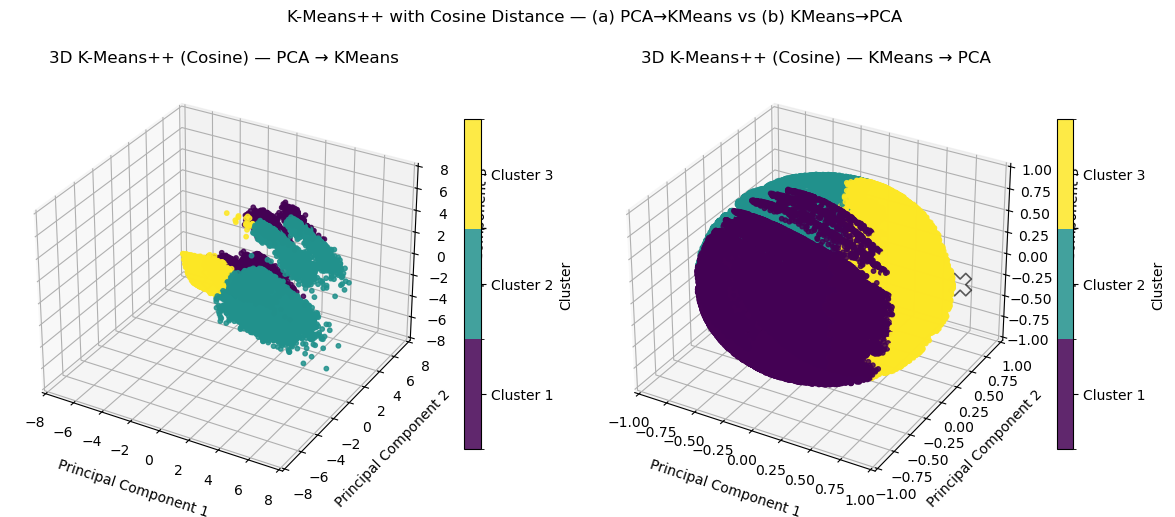

In [20]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

cmap, norm, ticks, ticklabels = discrete_viridis(K)

fig = plt.figure(figsize=(12,5))

# ---- (a) reduce dimension BEFORE clustering ----
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
sc1 = ax1.scatter(Z3_a[:,0], Z3_a[:,1], Z3_a[:,2],
                  s=10, alpha=0.85, c=labels_a, cmap=cmap, norm=norm)
ax1.scatter(centroids_a_pca[:,0], centroids_a_pca[:,1], centroids_a_pca[:,2],
            s=260, marker='X', edgecolor='black', linewidths=1.2, facecolor='none')
ax1.set_title("3D K-Means++ (Cosine) — PCA → KMeans")
ax1.set_xlabel("Principal Component 1", labelpad=8)
ax1.set_ylabel("Principal Component 2", labelpad=8)
ax1.set_zlabel("Principal Component 3", labelpad=8)
lim = np.max(np.abs(Z3_a)) * 1.05
ax1.set_xlim(-lim, lim); ax1.set_ylim(-lim, lim); ax1.set_zlim(-lim, lim)
cbar1 = fig.colorbar(sc1, ax=ax1, shrink=0.75, pad=0.05)
cbar1.set_ticks(ticks); cbar1.set_ticklabels(ticklabels); cbar1.set_label("Cluster")

# ---- (b) reduce dimension AFTER clustering ----
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
sc2 = ax2.scatter(Z3_b[:,0], Z3_b[:,1], Z3_b[:,2],
                  s=10, alpha=0.85, c=labels_b, cmap=cmap, norm=norm)
ax2.scatter(centroids_b_pca[:,0], centroids_b_pca[:,1], centroids_b_pca[:,2],
            s=260, marker='X', edgecolor='black', linewidths=1.2, facecolor='none')
ax2.set_title("3D K-Means++ (Cosine) — KMeans → PCA")
ax2.set_xlabel("Principal Component 1", labelpad=8)
ax2.set_ylabel("Principal Component 2", labelpad=8)
ax2.set_zlabel("Principal Component 3", labelpad=8)
lim2 = np.max(np.abs(Z3_b)) * 1.05
ax2.set_xlim(-lim2, lim2); ax2.set_ylim(-lim2, lim2); ax2.set_zlim(-lim2, lim2)
cbar2 = fig.colorbar(sc2, ax=ax2, shrink=0.75, pad=0.05)
cbar2.set_ticks(ticks); cbar2.set_ticklabels(ticklabels); cbar2.set_label("Cluster")

plt.suptitle("K-Means++ with Cosine Distance — (a) PCA→KMeans vs (b) KMeans→PCA", y=1.02)
plt.tight_layout()
plt.show()

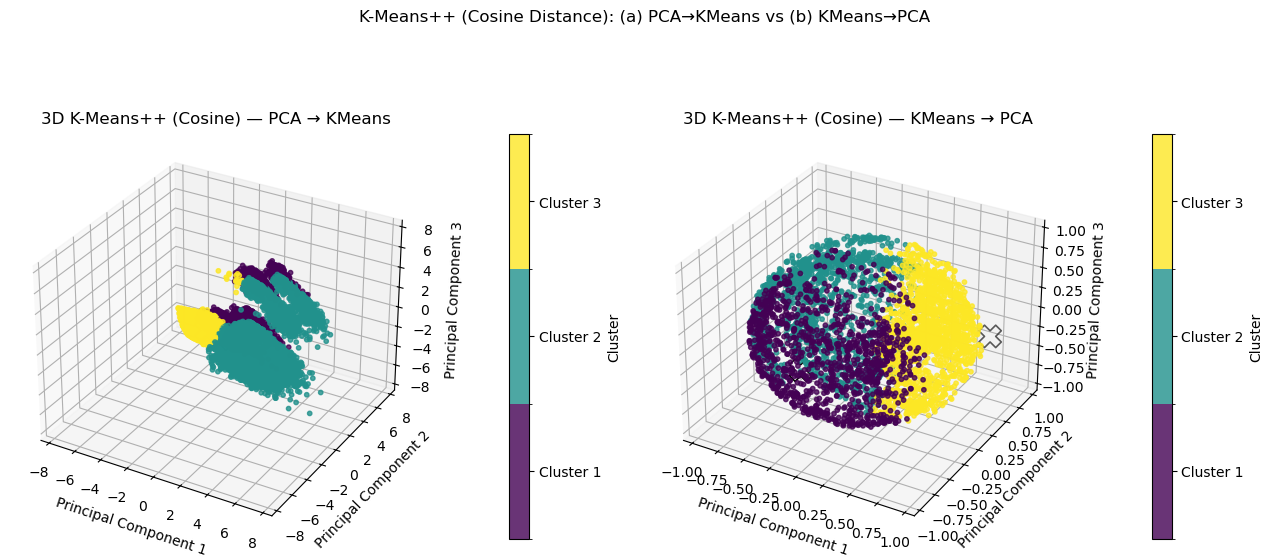

In [21]:
fig = plt.figure(figsize=(13,6))
from mpl_toolkits.mplot3d import Axes3D  # noqa

# ---- (a) PCA → KMeans ----
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
sc1 = ax1.scatter(Z3_a[:,0], Z3_a[:,1], Z3_a[:,2],
                  s=10, alpha=0.8, c=labels_a, cmap=cmap, norm=norm)
ax1.scatter(centroids_a_pca[:,0], centroids_a_pca[:,1], centroids_a_pca[:,2],
            s=260, marker='X', edgecolor='black', linewidths=1.2, facecolor='none')
ax1.set_title("3D K-Means++ (Cosine) — PCA → KMeans")
ax1.set_xlabel("Principal Component 1")
ax1.set_ylabel("Principal Component 2")
ax1.set_zlabel("Principal Component 3")
lim = np.max(np.abs(Z3_a)) * 1.1
ax1.set_xlim(-lim, lim); ax1.set_ylim(-lim, lim); ax1.set_zlim(-lim, lim)
# move colorbar outward
cbar1 = fig.colorbar(sc1, ax=ax1, shrink=0.75, pad=0.15, location='right')
cbar1.set_ticks(ticks); cbar1.set_ticklabels(ticklabels); cbar1.set_label("Cluster")

# ---- (b) KMeans → PCA ----
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
# sample subset to reduce density
n_show = min(4000, len(Z3_b))
idx = np.random.default_rng(42).choice(len(Z3_b), n_show, replace=False)
sc2 = ax2.scatter(Z3_b[idx,0], Z3_b[idx,1], Z3_b[idx,2],
                  s=10, alpha=0.8, c=labels_b[idx], cmap=cmap, norm=norm)
ax2.scatter(centroids_b_pca[:,0], centroids_b_pca[:,1], centroids_b_pca[:,2],
            s=260, marker='X', edgecolor='black', linewidths=1.2, facecolor='none')
ax2.set_title("3D K-Means++ (Cosine) — KMeans → PCA")
ax2.set_xlabel("Principal Component 1")
ax2.set_ylabel("Principal Component 2")
ax2.set_zlabel("Principal Component 3")
lim2 = np.max(np.abs(Z3_b)) * 1.1
ax2.set_xlim(-lim2, lim2); ax2.set_ylim(-lim2, lim2); ax2.set_zlim(-lim2, lim2)
# move colorbar outward as well
cbar2 = fig.colorbar(sc2, ax=ax2, shrink=0.75, pad=0.15, location='right')
cbar2.set_ticks(ticks); cbar2.set_ticklabels(ticklabels); cbar2.set_label("Cluster")

plt.suptitle("K-Means++ (Cosine Distance): (a) PCA→KMeans vs (b) KMeans→PCA", y=1.02)
plt.tight_layout()
plt.show()

In [3]:
# JUPYTER CELL 2 — load & preprocess
DATA_PATH = Path("world_bank_dataset.csv")  # change if using another file
df = pd.read_csv(DATA_PATH)

# numeric-only for KMeans
X = df.select_dtypes(include=[np.number]).copy()
# remove constant columns
X = X.loc[:, X.nunique(dropna=False) > 1]

pre = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler",  StandardScaler()),
])
Xs = pre.fit_transform(X)

print("Data shape after preprocessing:", Xs.shape)

Data shape after preprocessing: (200, 7)


In [4]:
# JUPYTER CELL 3 — PCA(3)
pca = PCA(n_components=3, random_state=42).fit(Xs)
Z3  = pca.transform(Xs)     # 3D coordinates for plotting or for "PCA-before" clustering
print("Explained variance ratio (3 PCs):", pca.explained_variance_ratio_)

Explained variance ratio (3 PCs): [0.17119597 0.16575291 0.16008311]


In [5]:
# JUPYTER CELL 4 — KMeans++ (Euclidean) before vs after PCA
K = 3  # choose the number of clusters you want to show

# (a) Reduce dimension BEFORE clustering
km_before = KMeans(n_clusters=K, init="k-means++", n_init=10, random_state=42)
labels_before = km_before.fit_predict(Z3)                   # cluster in 3D PCA space
centroids_before_pca = km_before.cluster_centers_           # already in PCA space

# (b) Reduce dimension AFTER clustering
km_after = KMeans(n_clusters=K, init="k-means++", n_init=10, random_state=42)
labels_after = km_after.fit_predict(Xs)                     # cluster in full scaled space (Euclidean)
centroids_after_pca = pca.transform(km_after.cluster_centers_)  # project centroids to PCA space

# quick sanity: silhouettes (optional)
sil_before = silhouette_score(Z3, labels_before, sample_size=min(10000, len(Z3)), random_state=42)
sil_after  = silhouette_score(Z3, labels_after,  sample_size=min(10000, len(Z3)), random_state=42)
print(f"Silhouette (PCA→KMeans): {sil_before:.3f}  |  Silhouette (KMeans→PCA): {sil_after:.3f}")

Silhouette (PCA→KMeans): 0.262  |  Silhouette (KMeans→PCA): 0.242


C:\Users\Omistaja\anaconda3\Anaconda\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\Omistaja\anaconda3\Anaconda\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\Omistaja\anaconda3\Anaconda\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Omistaja\anaconda3\Anaconda\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\Omistaja\anaconda3\Anaconda\Lib\subprocess.py", line 1538

In [6]:
# JUPYTER CELL 5 — color mapping helpers
def discrete_viridis(K):
    # a discrete version of viridis with K distinct colors
    cmap = plt.cm.get_cmap("viridis", K)
    norm = mcolors.BoundaryNorm(boundaries=np.arange(-0.5, K + 0.5, 1), ncolors=K)
    ticks = np.arange(K)
    ticklabels = [f"Cluster {i+1}" for i in range(K)]
    return cmap, norm, ticks, ticklabels

C:\Users\Omistaja\AppData\Local\Temp\ipykernel_22672\2851068314.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("viridis", K)


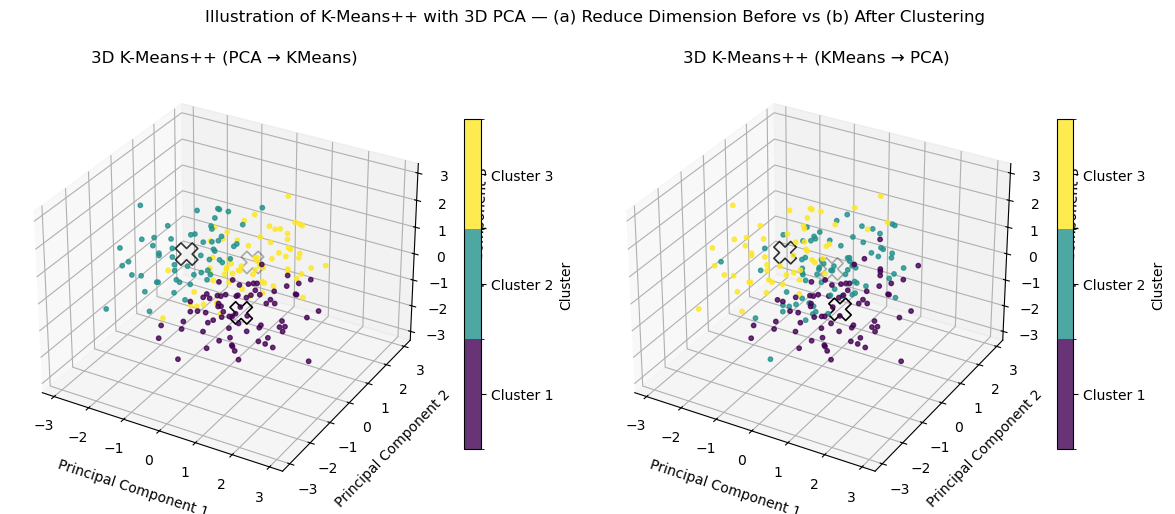

In [7]:
# JUPYTER CELL 6 — side-by-side 3D plots with viridis + centroids
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

cmap, norm, ticks, ticklabels = discrete_viridis(K)

fig = plt.figure(figsize=(12,5))

# ---------- (a) PCA before clustering ----------
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
sc1 = ax1.scatter(Z3[:,0], Z3[:,1], Z3[:,2],
                  s=10, alpha=0.8, c=labels_before, cmap=cmap, norm=norm)
ax1.scatter(centroids_before_pca[:,0], centroids_before_pca[:,1], centroids_before_pca[:,2],
            s=260, marker='X', edgecolor='black', linewidths=1.2, facecolor='none')
ax1.set_title("3D K-Means++ (PCA → KMeans)")
ax1.set_xlabel("Principal Component 1", labelpad=8)
ax1.set_ylabel("Principal Component 2", labelpad=8)
ax1.set_zlabel("Principal Component 3", labelpad=8)
lim = np.max(np.abs(Z3)) * 1.05
ax1.set_xlim(-lim, lim); ax1.set_ylim(-lim, lim); ax1.set_zlim(-lim, lim)
cbar1 = fig.colorbar(sc1, ax=ax1, shrink=0.75, pad=0.05)
cbar1.set_ticks(ticks); cbar1.set_ticklabels(ticklabels); cbar1.set_label("Cluster")

# ---------- (b) PCA after clustering ----------
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
sc2 = ax2.scatter(Z3[:,0], Z3[:,1], Z3[:,2],
                  s=10, alpha=0.8, c=labels_after, cmap=cmap, norm=norm)
ax2.scatter(centroids_after_pca[:,0], centroids_after_pca[:,1], centroids_after_pca[:,2],
            s=260, marker='X', edgecolor='black', linewidths=1.2, facecolor='none')
ax2.set_title("3D K-Means++ (KMeans → PCA)")
ax2.set_xlabel("Principal Component 1", labelpad=8)
ax2.set_ylabel("Principal Component 2", labelpad=8)
ax2.set_zlabel("Principal Component 3", labelpad=8)
ax2.set_xlim(-lim, lim); ax2.set_ylim(-lim, lim); ax2.set_zlim(-lim, lim)
cbar2 = fig.colorbar(sc2, ax=ax2, shrink=0.75, pad=0.05)
cbar2.set_ticks(ticks); cbar2.set_ticklabels(ticklabels); cbar2.set_label("Cluster")

plt.suptitle("Illustration of K-Means++ with 3D PCA — (a) Reduce Dimension Before vs (b) After Clustering", y=1.02)
plt.tight_layout()
plt.show()

C:\Users\Omistaja\AppData\Local\Temp\ipykernel_22672\2876907531.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("viridis", K)


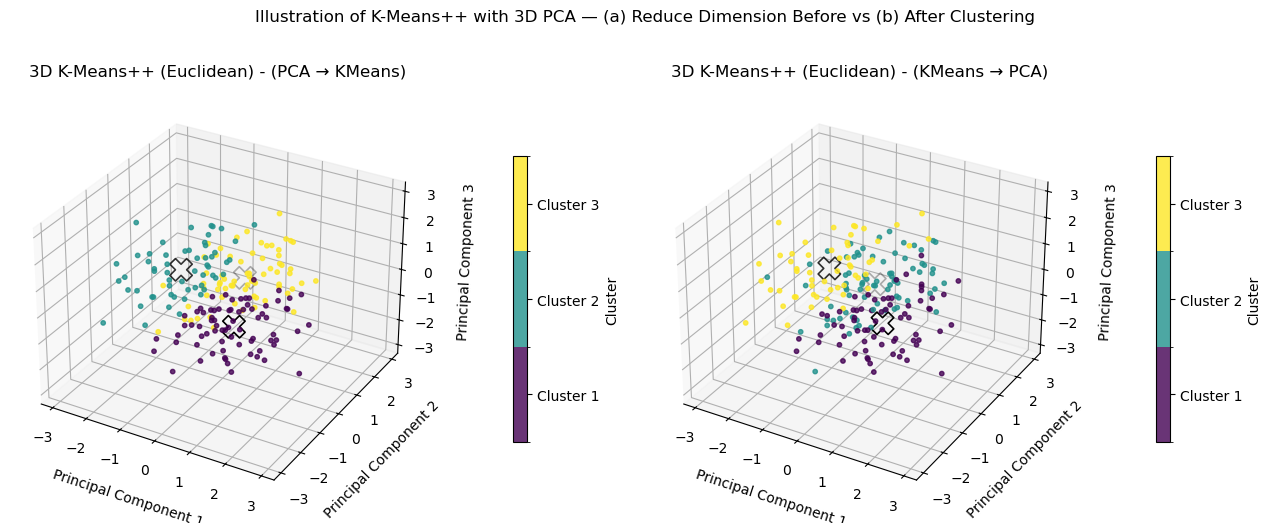

In [17]:
# JUPYTER CELL 6 — side-by-side 3D plots with viridis + centroids (fixed colorbar position)
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

cmap, norm, ticks, ticklabels = discrete_viridis(K)

fig = plt.figure(figsize=(13, 5))

# ---------- (a) PCA before clustering ----------
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
sc1 = ax1.scatter(Z3[:, 0], Z3[:, 1], Z3[:, 2],
                  s=10, alpha=0.8, c=labels_before, cmap=cmap, norm=norm)
ax1.scatter(centroids_before_pca[:, 0], centroids_before_pca[:, 1], centroids_before_pca[:, 2],
            s=260, marker='X', edgecolor='black', linewidths=1.2, facecolor='none')
ax1.set_title("3D K-Means++ (Euclidean) - (PCA → KMeans)", pad=12)
ax1.set_xlabel("Principal Component 1", labelpad=8)
ax1.set_ylabel("Principal Component 2", labelpad=8)
ax1.set_zlabel("Principal Component 3", labelpad=8)
lim = np.max(np.abs(Z3)) * 1.05
ax1.set_xlim(-lim, lim); ax1.set_ylim(-lim, lim); ax1.set_zlim(-lim, lim)

# Adjust colorbar placement for (a)
cbar1 = fig.colorbar(sc1, ax=ax1, shrink=0.65, pad=0.15, location='right')
cbar1.set_ticks(ticks)
cbar1.set_ticklabels(ticklabels)
cbar1.set_label("Cluster")

# ---------- (b) PCA after clustering ----------
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
sc2 = ax2.scatter(Z3[:, 0], Z3[:, 1], Z3[:, 2],
                  s=10, alpha=0.8, c=labels_after, cmap=cmap, norm=norm)
ax2.scatter(centroids_after_pca[:, 0], centroids_after_pca[:, 1], centroids_after_pca[:, 2],
            s=260, marker='X', edgecolor='black', linewidths=1.2, facecolor='none')
ax2.set_title("3D K-Means++ (Euclidean) - (KMeans → PCA)", pad=12)
ax2.set_xlabel("Principal Component 1", labelpad=8)
ax2.set_ylabel("Principal Component 2", labelpad=8)
ax2.set_zlabel("Principal Component 3", labelpad=8)
ax2.set_xlim(-lim, lim); ax2.set_ylim(-lim, lim); ax2.set_zlim(-lim, lim)

# Adjust colorbar placement for (b)
cbar2 = fig.colorbar(sc2, ax=ax2, shrink=0.65, pad=0.15, location='right')
cbar2.set_ticks(ticks)
cbar2.set_ticklabels(ticklabels)
cbar2.set_label("Cluster")

plt.suptitle("Illustration of K-Means++ with 3D PCA — (a) Reduce Dimension Before vs (b) After Clustering", y=1.05)
plt.tight_layout()
plt.show()

In [12]:
def l2_normalize_rows(A, eps=1e-12):
    norms = np.linalg.norm(A, axis=1, keepdims=True)
    return A / np.clip(norms, eps, None)

def discrete_viridis(K):
    cmap = plt.cm.get_cmap("viridis", K)
    norm = mcolors.BoundaryNorm(boundaries=np.arange(-0.5, K+0.5, 1), ncolors=K)
    ticks = np.arange(K)
    ticklabels = [f"Cluster {i+1}" for i in range(K)]
    return cmap, norm, ticks, ticklabels

def spherical_kmeans(X_unit, K, max_iter=100, tol=1e-4, random_state=42):
    """
    Spherical k-means with k-means++ initialization under cosine distance.
    X_unit must be L2-normalized row-wise (||x||=1). Returns (labels, centroids_unit).
    """
    rng = np.random.default_rng(random_state)
    n, d = X_unit.shape

    # --- k-means++ init under cosine distance (distance = 1 - cos)
    # pick first centroid randomly
    first = rng.integers(0, n)
    centroids = [X_unit[first]]

    # subsequent centroids
    for _ in range(1, K):
        # cosine similarity to nearest chosen centroid
        sims = np.max(X_unit @ np.vstack(centroids).T, axis=1)
        dist = 1.0 - sims
        probs = np.square(dist)
        probs_sum = probs.sum()
        if probs_sum <= 0:
            idx = rng.integers(0, n)
        else:
            probs = probs / probs_sum
            idx = rng.choice(n, p=probs)
        centroids.append(X_unit[idx])

    C = np.vstack(centroids)           # shape (K, d)
    C = l2_normalize_rows(C)           # ensure unit centroids

    labels = np.full(n, -1, dtype=int)
    for it in range(max_iter):
        # assign to nearest by cosine: argmax dot(x, c)
        scores = X_unit @ C.T          # (n, K)
        new_labels = np.argmax(scores, axis=1)

        # check convergence
        changes = np.mean(new_labels != labels) if labels[0] != -1 else 1.0
        labels = new_labels
        if changes < tol:
            break

        # update centroids (mean of assigned, then renormalize)
        for k in range(K):
            idx = (labels == k)
            if idx.any():
                C[k] = l2_normalize_rows(X_unit[idx].mean(axis=0, keepdims=True))[0]
            else:
                # empty cluster: re-seed to farthest point
                sims = np.max(X_unit @ C.T, axis=1)
                far_idx = np.argmin(sims)
                C[k] = X_unit[far_idx]
    return labels, C

In [13]:
K = 3  # number of clusters for display

# ---------- (a) PCA before clustering ----------
pca_a = PCA(n_components=3, random_state=42).fit(Xs)
Z3_a = pca_a.transform(Xs)              # 3D coordinates
Z3_a_unit = l2_normalize_rows(Z3_a)     # unit vectors for cosine
labels_a, C_a_unit = spherical_kmeans(Z3_a_unit, K, random_state=42)
# centroids already in PCA space (unit-norm)
centroids_a_pca = C_a_unit

# ---------- (b) PCA after clustering ----------
Xs_unit = l2_normalize_rows(Xs)
labels_b, C_b_unit = spherical_kmeans(Xs_unit, K, random_state=42)

pca_b = PCA(n_components=3, random_state=42).fit(Xs_unit)
Z3_b = pca_b.transform(Xs_unit)
centroids_b_pca = pca_b.transform(C_b_unit)

In [14]:
sil_a = silhouette_score(Z3_a, labels_a, metric="cosine",
                         sample_size=min(10000, len(Z3_a)), random_state=42)
sil_b = silhouette_score(Xs_unit, labels_b, metric="cosine",
                         sample_size=min(10000, len(Xs_unit)), random_state=42)
print(f"Silhouette (cosine) — PCA→KMeans: {sil_a:.3f} | KMeans→PCA: {sil_b:.3f}")

Silhouette (cosine) — PCA→KMeans: 0.468 | KMeans→PCA: 0.209


C:\Users\Omistaja\AppData\Local\Temp\ipykernel_22672\2876907531.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("viridis", K)


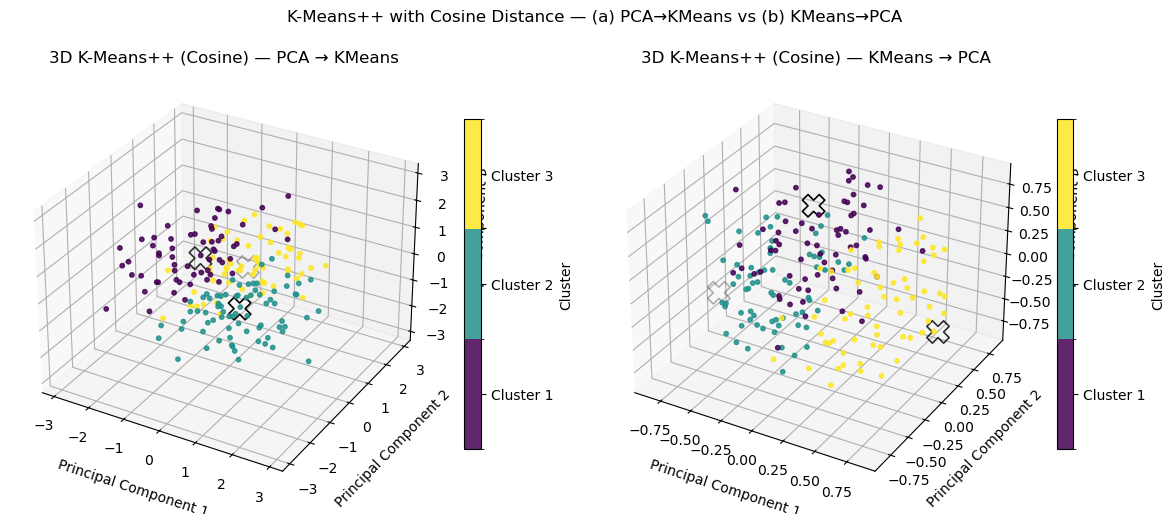

In [15]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

cmap, norm, ticks, ticklabels = discrete_viridis(K)

fig = plt.figure(figsize=(12,5))

# ---- (a) reduce dimension BEFORE clustering ----
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
sc1 = ax1.scatter(Z3_a[:,0], Z3_a[:,1], Z3_a[:,2],
                  s=10, alpha=0.85, c=labels_a, cmap=cmap, norm=norm)
ax1.scatter(centroids_a_pca[:,0], centroids_a_pca[:,1], centroids_a_pca[:,2],
            s=260, marker='X', edgecolor='black', linewidths=1.2, facecolor='none')
ax1.set_title("3D K-Means++ (Cosine) — PCA → KMeans")
ax1.set_xlabel("Principal Component 1", labelpad=8)
ax1.set_ylabel("Principal Component 2", labelpad=8)
ax1.set_zlabel("Principal Component 3", labelpad=8)
lim = np.max(np.abs(Z3_a)) * 1.05
ax1.set_xlim(-lim, lim); ax1.set_ylim(-lim, lim); ax1.set_zlim(-lim, lim)
cbar1 = fig.colorbar(sc1, ax=ax1, shrink=0.75, pad=0.05)
cbar1.set_ticks(ticks); cbar1.set_ticklabels(ticklabels); cbar1.set_label("Cluster")

# ---- (b) reduce dimension AFTER clustering ----
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
sc2 = ax2.scatter(Z3_b[:,0], Z3_b[:,1], Z3_b[:,2],
                  s=10, alpha=0.85, c=labels_b, cmap=cmap, norm=norm)
ax2.scatter(centroids_b_pca[:,0], centroids_b_pca[:,1], centroids_b_pca[:,2],
            s=260, marker='X', edgecolor='black', linewidths=1.2, facecolor='none')
ax2.set_title("3D K-Means++ (Cosine) — KMeans → PCA")
ax2.set_xlabel("Principal Component 1", labelpad=8)
ax2.set_ylabel("Principal Component 2", labelpad=8)
ax2.set_zlabel("Principal Component 3", labelpad=8)
lim2 = np.max(np.abs(Z3_b)) * 1.05
ax2.set_xlim(-lim2, lim2); ax2.set_ylim(-lim2, lim2); ax2.set_zlim(-lim2, lim2)
cbar2 = fig.colorbar(sc2, ax=ax2, shrink=0.75, pad=0.05)
cbar2.set_ticks(ticks); cbar2.set_ticklabels(ticklabels); cbar2.set_label("Cluster")

plt.suptitle("K-Means++ with Cosine Distance — (a) PCA→KMeans vs (b) KMeans→PCA", y=1.02)
plt.tight_layout()
plt.show()

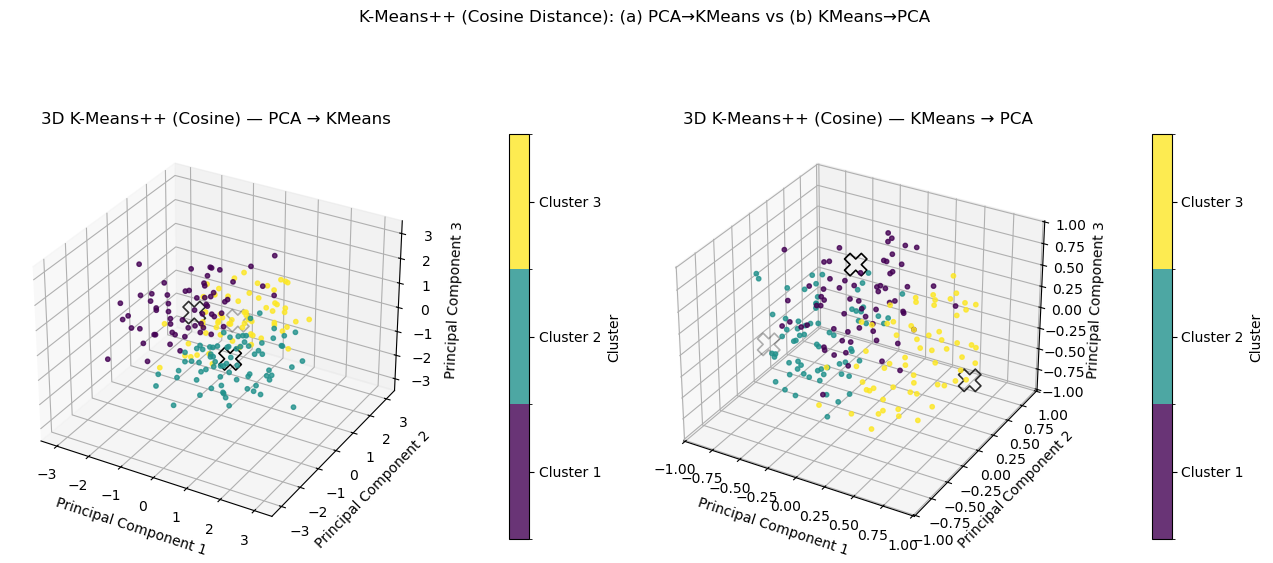

In [16]:
fig = plt.figure(figsize=(13,6))
from mpl_toolkits.mplot3d import Axes3D  # noqa

# ---- (a) PCA → KMeans ----
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
sc1 = ax1.scatter(Z3_a[:,0], Z3_a[:,1], Z3_a[:,2],
                  s=10, alpha=0.8, c=labels_a, cmap=cmap, norm=norm)
ax1.scatter(centroids_a_pca[:,0], centroids_a_pca[:,1], centroids_a_pca[:,2],
            s=260, marker='X', edgecolor='black', linewidths=1.2, facecolor='none')
ax1.set_title("3D K-Means++ (Cosine) — PCA → KMeans")
ax1.set_xlabel("Principal Component 1")
ax1.set_ylabel("Principal Component 2")
ax1.set_zlabel("Principal Component 3")
lim = np.max(np.abs(Z3_a)) * 1.1
ax1.set_xlim(-lim, lim); ax1.set_ylim(-lim, lim); ax1.set_zlim(-lim, lim)
# move colorbar outward
cbar1 = fig.colorbar(sc1, ax=ax1, shrink=0.75, pad=0.15, location='right')
cbar1.set_ticks(ticks); cbar1.set_ticklabels(ticklabels); cbar1.set_label("Cluster")

# ---- (b) KMeans → PCA ----
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
# sample subset to reduce density
n_show = min(4000, len(Z3_b))
idx = np.random.default_rng(42).choice(len(Z3_b), n_show, replace=False)
sc2 = ax2.scatter(Z3_b[idx,0], Z3_b[idx,1], Z3_b[idx,2],
                  s=10, alpha=0.8, c=labels_b[idx], cmap=cmap, norm=norm)
ax2.scatter(centroids_b_pca[:,0], centroids_b_pca[:,1], centroids_b_pca[:,2],
            s=260, marker='X', edgecolor='black', linewidths=1.2, facecolor='none')
ax2.set_title("3D K-Means++ (Cosine) — KMeans → PCA")
ax2.set_xlabel("Principal Component 1")
ax2.set_ylabel("Principal Component 2")
ax2.set_zlabel("Principal Component 3")
lim2 = np.max(np.abs(Z3_b)) * 1.1
ax2.set_xlim(-lim2, lim2); ax2.set_ylim(-lim2, lim2); ax2.set_zlim(-lim2, lim2)
# move colorbar outward as well
cbar2 = fig.colorbar(sc2, ax=ax2, shrink=0.75, pad=0.15, location='right')
cbar2.set_ticks(ticks); cbar2.set_ticklabels(ticklabels); cbar2.set_label("Cluster")

plt.suptitle("K-Means++ (Cosine Distance): (a) PCA→KMeans vs (b) KMeans→PCA", y=1.02)
plt.tight_layout()
plt.show()

# Experimental Analysis
# World Bank Dataset

In [19]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import mutual_info_regression
from IPython.display import display 

In [21]:
#path to your CSV
DATA_PATH = "world_bank_dataset.csv"  # adjust if needed

# Load numeric features only (drop constants)
raw = pd.read_csv(DATA_PATH)
num = raw.select_dtypes(include=[np.number]).copy()
num = num.loc[:, num.nunique(dropna=False) > 1]  # remove constant columns
print(f"Rows: {len(num):,} | Numeric features kept: {num.shape[1]}")

# Impute + scale (keep objects for inverse-transform)
imp = SimpleImputer(strategy="median")
X_imp = imp.fit_transform(num)
scaler = StandardScaler()
Xs = scaler.fit_transform(X_imp)

feature_names = num.columns.tolist()

Rows: 200 | Numeric features kept: 7


In [22]:
k_grid = [2,3,4,5,6]
rows = []
best_k, best_s = None, -1.0

for k in k_grid:
    km = KMeans(n_clusters=k, init="k-means++", n_init=10, random_state=42)
    labels = km.fit_predict(Xs)
    s = silhouette_score(Xs, labels, sample_size=min(8000, len(Xs)), random_state=42)
    rows.append({"K": k, "Inertia": km.inertia_, "Silhouette": s})
    if s > best_s:
        best_k, best_s = k, s

k_selection = pd.DataFrame(rows)
display(k_selection.style.format({"Inertia": "{:,.0f}", "Silhouette": "{:.4f}"}))
print(f"Chosen K by Silhouette: {best_k} (score={best_s:.4f})")

# Optional: save
k_selection.to_csv("worldbank_kmeans_k_selection.csv", index=False)

C:\Users\Omistaja\anaconda3\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Omistaja\anaconda3\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Omistaja\anaconda3\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Omistaja\anaconda3\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

,K,Inertia,Silhouette
0,2,"1,232",0.1145
1,3,"1,099",0.1237
2,4,"1,017",0.1213
3,5,934,0.1328
4,6,873,0.1332


Chosen K by Silhouette: 6 (score=0.1332)


In [23]:
km = KMeans(n_clusters=best_k, init="k-means++", n_init=20, random_state=42)
labels = km.fit_predict(Xs)

inertia = km.inertia_
sizes = pd.Series(labels).value_counts().sort_index()
sizes_df = pd.DataFrame({"cluster_id": sizes.index, "size": sizes.values})

# Back-transform centroids from scaled space to original units
centroids_scaled = km.cluster_centers_
centroids_orig = scaler.inverse_transform(centroids_scaled)
centroids_df = pd.DataFrame(centroids_orig, columns=feature_names)
centroids_df.insert(0, "cluster_id", np.arange(best_k))

print(f"Inertia: {inertia:,.4f}")
display(sizes_df)
display(centroids_df.head())     # full table may be wide

# Save for your report
centroids_df.to_csv("worldbank_kmeanspp_centroids.csv", index=False)
sizes_df.to_csv("worldbank_kmeanspp_cluster_sizes.csv", index=False)

Inertia: 873.0065


C:\Users\Omistaja\anaconda3\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


,cluster_id,size
0,0,32
1,1,28
2,2,37
3,3,32
4,4,33
5,5,38


,cluster_id,Year,GDP (USD),Population,Life Expectancy,Unemployment Rate (%),CO2 Emissions (metric tons per capita),Access to Electricity (%)
0,0,2016.468750,1.041129e+13,9.308294e+08,61.612500,16.284375,5.007812,64.774062
1,1,2016.107143,9.121870e+12,1.222024e+09,61.039286,12.636071,13.133571,87.675357
2,2,2016.891892,1.183288e+13,5.604138e+08,75.083784,8.550000,11.532703,63.481081
3,3,2013.281250,7.926440e+12,3.259450e+08,65.600000,15.842500,16.130625,68.785625
4,4,2011.636364,1.707647e+13,8.325115e+08,63.536364,15.261212,9.313333,65.432121


In [24]:
def pick_target_col(df_all, df_num, keys):
    cands = [c for c in df_all.columns if any(k in c.lower() for k in keys)]
    # keep only numeric & with data
    cands = [c for c in cands if c in df_num.columns and df_all[c].notna().sum() > 0]
    if not cands:
        return None
    # pick the one with the most non-nulls
    cands.sort(key=lambda c: df_all[c].notna().sum(), reverse=True)
    return cands[0]

gdp_col  = pick_target_col(raw, num, ["gdp"])
life_col = pick_target_col(raw, num, ["life", "expect"])

print("Detected targets:")
print("  GDP column        :", gdp_col)
print("  Life expectancy   :", life_col)

Detected targets:
  GDP column        : GDP (USD)
  Life expectancy   : Life Expectancy


In [25]:
def rank_feature_contributions(df_num, target_col, top_n=12):
    X = df_num.drop(columns=[target_col], errors="ignore")
    y = df_num[target_col].copy()
    # Impute predictors; fill target with its median
    X_imp = SimpleImputer(strategy="median").fit_transform(X)
    y_imp = y.fillna(y.median()).values

    # Random Forest importance (nonlinear, handles interactions)
    rf = RandomForestRegressor(n_estimators=400, random_state=42, n_jobs=-1)
    rf.fit(X_imp, y_imp)
    rf_imp = pd.Series(rf.feature_importances_, index=X.columns, name="rf_importance")

    # |Pearson correlation|
    corrs = []
    for j in range(X_imp.shape[1]):
        xj = X_imp[:, j]
        if np.std(xj) == 0 or np.std(y_imp) == 0:
            corrs.append(0.0)
        else:
            corrs.append(np.corrcoef(xj, y_imp)[0, 1])
    corr = pd.Series(np.abs(corrs), index=X.columns, name="pearson_corr")

    # Mutual information (captures non-linear dependence)
    try:
        mi = pd.Series(mutual_info_regression(X_imp, y_imp, random_state=42),
                       index=X.columns, name="mutual_info")
    except Exception:
        mi = pd.Series(0.0, index=X.columns, name="mutual_info")

    # Normalize each metric 0..1 and average for a simple, robust score
    feat = pd.concat([rf_imp, corr, mi], axis=1).fillna(0.0)
    for col in feat.columns:
        m = feat[col].max()
        if m > 0:
            feat[col] = feat[col] / m
    feat["avg_score"] = feat.mean(axis=1)
    feat = feat.sort_values("avg_score", ascending=False)

    top = feat.head(top_n).round(4)
    return top, feat

plots = []
for name, tcol in [("GDP", gdp_col), ("Life Expectancy", life_col)]:
    if tcol is None:
        print(f"[skip] Could not find a numeric column for {name}.")
        continue
    top, full = rank_feature_contributions(num, tcol, top_n=12)
    display(pd.DataFrame({"feature": top.index, **top}).set_index("feature"))
    # Bar plot
    plt.figure(figsize=(7,4))
    plt.barh(top.index[::-1], top["avg_score"][::-1])
    plt.xlabel("Normalized importance (avg of RF, |corr|, MI)")
    plt.title(f"Top features contributing to {name}")
    plt.tight_layout()
    out_png = f"worldbank_feature_contrib_{name.replace(' ', '_').lower()}.png"
    plt.savefig(out_png, dpi=160)
    plots.append(out_png)
    # Save table
    top.to_csv(f"worldbank_feature_contrib_{name.replace(' ', '_').lower()}.csv")

print("Saved:", plots)

,rf_importance,pearson_corr,mutual_info,avg_score
feature,,,,
Access to Electricity (%),1.0000,1.0000,0.0000,0.6667
CO2 Emissions (metric tons per capita),0.8377,0.0260,1.0000,0.6212
Unemployment Rate (%),0.8301,0.0804,0.3676,0.4260
Life Expectancy,0.8380,0.3835,0.0000,0.4072
Population,0.8194,0.2678,0.0000,0.3624
Year,0.5305,0.0283,0.0908,0.2165


,rf_importance,pearson_corr,mutual_info,avg_score
feature,,,,
Population,1.0000,1.0000,0.7146,0.9049
Access to Electricity (%),0.8587,0.5978,1.0000,0.8188
CO2 Emissions (metric tons per capita),0.9445,0.2309,0.7326,0.6360
Unemployment Rate (%),0.7267,0.8928,0.0000,0.5398
GDP (USD),0.9271,0.5729,0.0000,0.5000
Year,0.5160,0.0693,0.0971,0.2274


Saved: ['worldbank_feature_contrib_gdp.png', 'worldbank_feature_contrib_life_expectancy.png']


In [26]:
km = KMeans(n_clusters=K, init="k-means++", n_init=20, random_state=42)
labels = km.fit_predict(Xs)
clusters = pd.Series(labels, name="Cluster") + 1   # 1..K for display

C:\Users\Omistaja\anaconda3\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [66]:
def pick_col(df, keys):
    cands = [c for c in df.columns if any(k in c.lower() for k in keys)]
    if not cands: 
        return None
    # pick the numerically-typed candidate with most non-nulls
    cands = [c for c in cands if c in df.select_dtypes(include=[np.number]).columns]
    if not cands:
        return None
    cands.sort(key=lambda c: df[c].notna().sum(), reverse=True)
    return cands[0]

pop_col  = pick_col(raw, ["population"])
elec_col = pick_col(raw, ["access to electricity", "electricity"])
unemp_col = pick_col(raw, ["unemployment"])  # we’ll convert to Employment = 100 − Unemployment
emp_col  = pick_col(raw, ["employment rate"])  # if present directly

# Build a tidy DataFrame with the three series we need
plot_df = pd.DataFrame({"Cluster": clusters})

# Population
if pop_col is not None:
    plot_df["Population"] = raw[pop_col]
else:
    raise ValueError("Couldn't find a numeric 'Population' column.")

# Employment rate
if emp_col is not None:
    plot_df["Unemployment Rate (%)"] = raw[emp_col]
elif unemp_col is not None:
    plot_df["Unemployment Rate (%)"] = 100.0 - raw[unemp_col]
else:
    raise ValueError("Couldn't find Employment or Unemployment column to derive employment rate.")

# Access to electricity
if elec_col is not None:
    # assume it's already in percent (0–100). If 0–1 scale, uncomment next line.
    # if plot_df[elec_col].max() <= 1.0: raw[elec_col] = raw[elec_col] * 100
    plot_df["Access to Electricity (%)"] = raw[elec_col]
else:
    raise ValueError("Couldn't find 'Access to Electricity' column.")

# Optional: drop rows with all-three missing
plot_df = plot_df.dropna(subset=["Population", "Unemployment Rate (%)", "Access to Electricity (%)"], how="all")

C:\Users\Omistaja\AppData\Local\Temp\ipykernel_22672\2119536621.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(
C:\Users\Omistaja\AppData\Local\Temp\ipykernel_22672\2119536621.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(
C:\Users\Omistaja\AppData\Local\Temp\ipykernel_22672\2119536621.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(


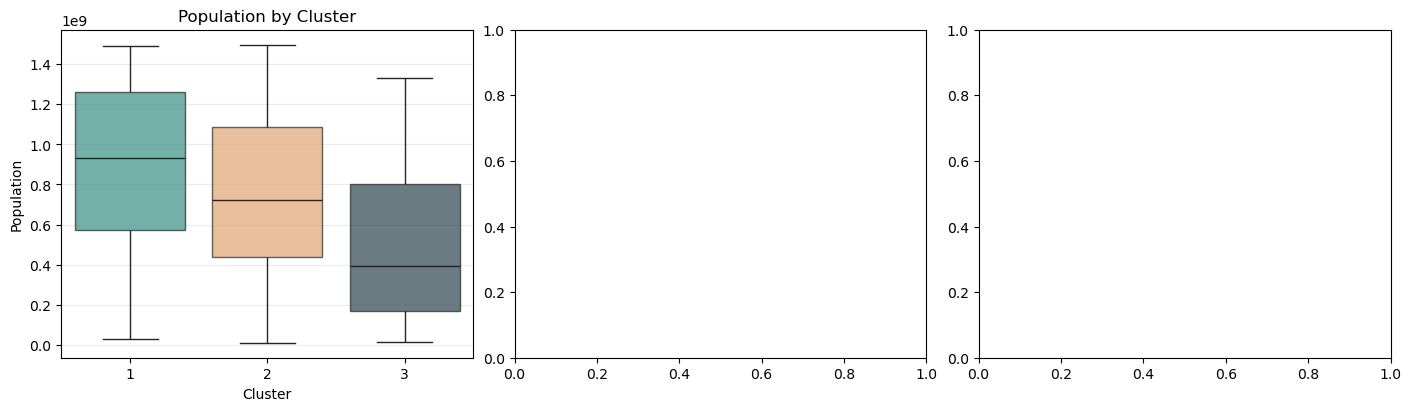

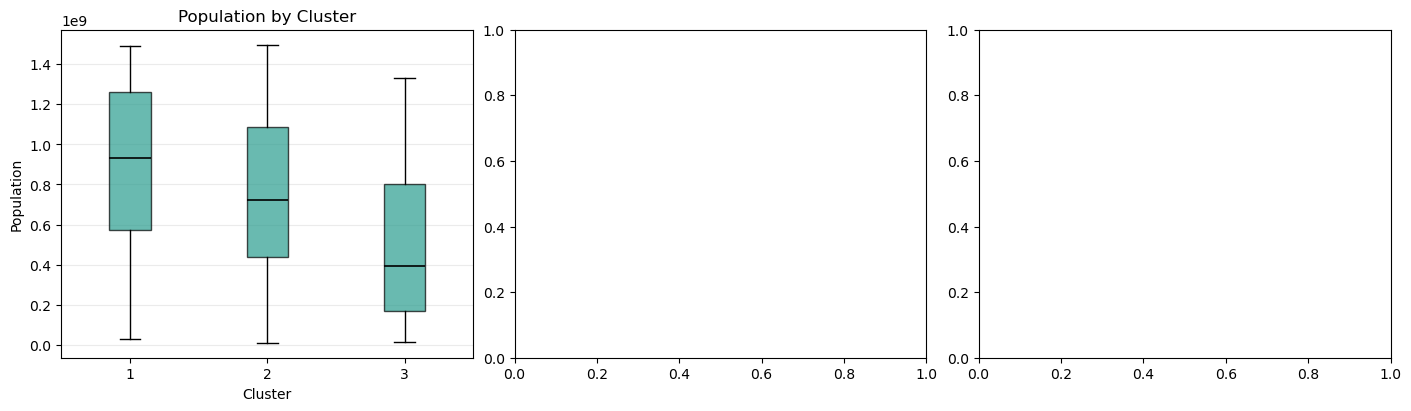

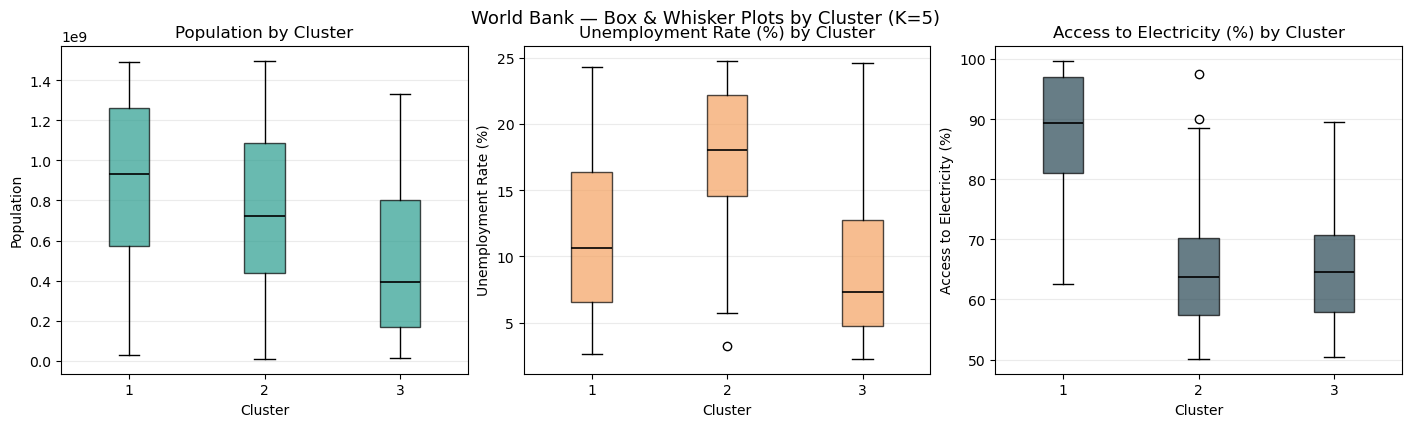

In [67]:
# ---------- 4) Box & Whisker plots (matplotlib only) ----------
features = ["Population", "Unemployment Rate (%)", "Access to Electricity (%)"]

fig, axes = plt.subplots(1, 3, figsize=(14, 4), constrained_layout=True)

for ax, feat in zip(axes, features):
    data_by_cluster = [plot_df.loc[plot_df["Cluster"] == c, feat].dropna().values for c in range(1, K+1)]
    # Create boxplot
    bp = ax.boxplot(
        data_by_cluster,
        labels=[str(c) for c in range(1, K+1)],
        patch_artist=True,
        showfliers=True,   # show outliers
        medianprops=dict(color="black", linewidth=1.2),
        boxprops=dict(linewidth=1.0),
        whiskerprops=dict(linewidth=1.0),
        capprops=dict(linewidth=1.0),
    )
    # Colors per feature for readability
    color_map = {
        "Population": "#2A9D8F",
        "Unemployment Rate (%)": "#F4A261",
        "Access to Electricity (%)": "#264653",
    }
    for patch in bp["boxes"]:
        patch.set_facecolor(color_map.get(feat, "#6c757d"))
        patch.set_alpha(0.7)

    ax.set_title(f"{feat} by Cluster")
    ax.set_xlabel("Cluster")
    ax.set_ylabel(feat)
    ax.grid(True, axis="y", alpha=0.25)

fig.suptitle("World Bank — Box & Whisker Plots by Cluster (K=5)", y=1.03, fontsize=13)
plt.show()

C:\Users\Omistaja\AppData\Local\Temp\ipykernel_22672\4103756969.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\Omistaja\AppData\Local\Temp\ipykernel_22672\4103756969.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\Omistaja\AppData\Local\Temp\ipykernel_22672\4103756969.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


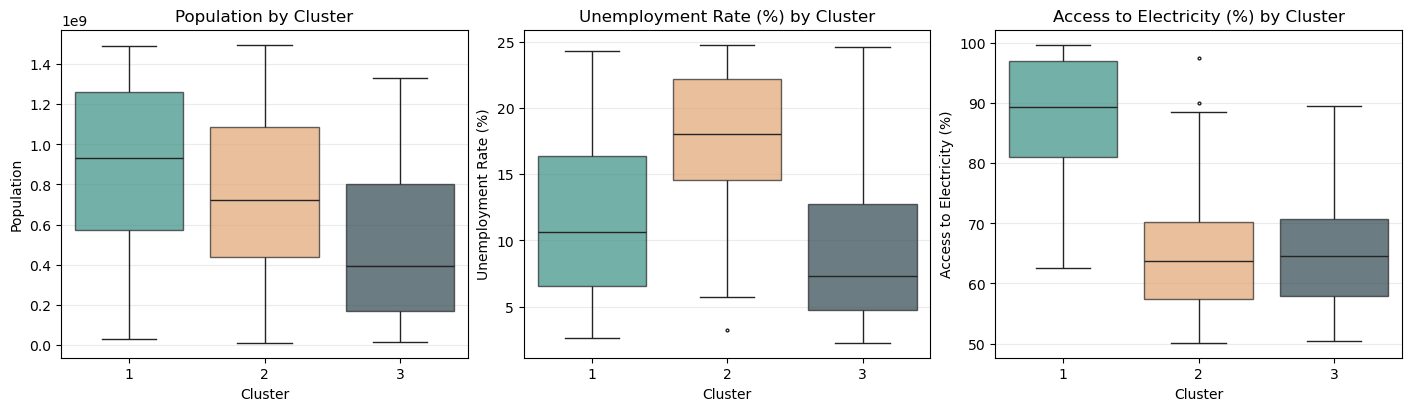

In [68]:
import seaborn as sns

# Choose 3 colors for clusters 1–3 (expand if you have more)
cluster_colors = {
    1: "#2A9D8F",  # teal
    2: "#F4A261",  # orange
    3: "#264653",  # navy
    4: "#E9C46A",  # gold (if you have K=5)
    5: "#A06CD5",  # violet
}

features = ["Population", "Unemployment Rate (%)", "Access to Electricity (%)"]
fig, axes = plt.subplots(1, 3, figsize=(14, 4), constrained_layout=True)

for ax, feat in zip(axes, features):
    # Make sure to drop NaNs
    data = plot_df[["Cluster", feat]].dropna()
    
    sns.boxplot(
        x="Cluster",
        y=feat,
        data=data,
        palette=[cluster_colors.get(c, "#999999") for c in sorted(data["Cluster"].unique())],
        ax=ax,
        fliersize=2,
        linewidth=1,
        boxprops=dict(alpha=0.7)
    )

    ax.set_title(f"{feat} by Cluster")
    ax.set_xlabel("Cluster")
    ax.set_ylabel(feat)
    ax.grid(True, axis="y", alpha=0.25)

plt.show()

In [31]:
# Define range for K
K_range = range(2, 11)

# Initialize metric containers
inertia_vals = []
silhouette_vals = []
db_vals = []
ch_vals = []

# Compute metrics for each K
for k in K_range:
    kmeans = KMeans(n_clusters=k, init="k-means++", n_init=20, random_state=42)
    labels = kmeans.fit_predict(X)
    
    inertia_vals.append(kmeans.inertia_)
    silhouette_vals.append(silhouette_score(X, labels))
    db_vals.append(davies_bouldin_score(X, labels))
    ch_vals.append(calinski_harabasz_score(X, labels))

C:\Users\Omistaja\anaconda3\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Omistaja\anaconda3\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Omistaja\anaconda3\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Omistaja\anaconda3\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

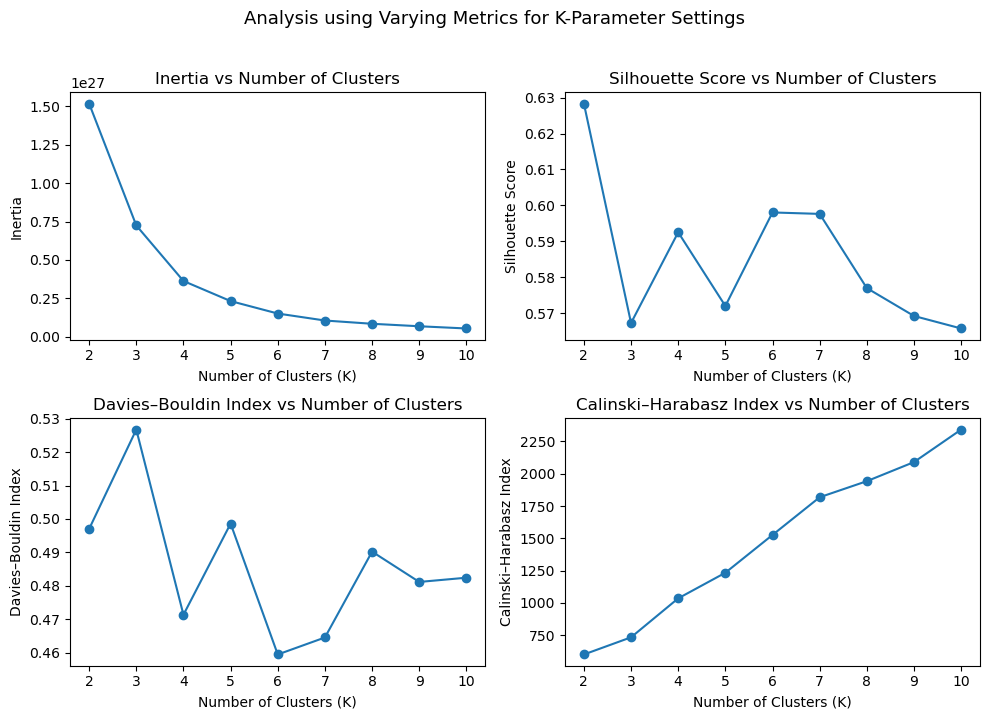

In [32]:
# --- Plot all metrics ---
fig, axes = plt.subplots(2, 2, figsize=(10, 7))
fig.suptitle("Analysis using Varying Metrics for K-Parameter Settings", fontsize=13, y=1.02)

# Inertia
axes[0, 0].plot(K_range, inertia_vals, marker="o")
axes[0, 0].set_title("Inertia vs Number of Clusters")
axes[0, 0].set_xlabel("Number of Clusters (K)")
axes[0, 0].set_ylabel("Inertia")

# Silhouette
axes[0, 1].plot(K_range, silhouette_vals, marker="o")
axes[0, 1].set_title("Silhouette Score vs Number of Clusters")
axes[0, 1].set_xlabel("Number of Clusters (K)")
axes[0, 1].set_ylabel("Silhouette Score")

# Davies–Bouldin
axes[1, 0].plot(K_range, db_vals, marker="o")
axes[1, 0].set_title("Davies–Bouldin Index vs Number of Clusters")
axes[1, 0].set_xlabel("Number of Clusters (K)")
axes[1, 0].set_ylabel("Davies–Bouldin Index")

# Calinski–Harabasz
axes[1, 1].plot(K_range, ch_vals, marker="o")
axes[1, 1].set_title("Calinski–Harabasz Index vs Number of Clusters")
axes[1, 1].set_xlabel("Number of Clusters (K)")
axes[1, 1].set_ylabel("Calinski–Harabasz Index")

plt.tight_layout()
plt.show()

# Diabetes Prediction Dataset

In [40]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import LogisticRegression

In [37]:
CSV = "diabetes_prediction_dataset.csv"   # adjust path if needed
df = pd.read_csv(CSV)

# Detect a diabetes label (binary) by name
label_candidates = [c for c in df.columns if any(k in c.lower() for k in ["diabetes","outcome","label","target"])]
y_col = None
for c in label_candidates:
    # keep a column with 2 unique values after dropping NaNs
    if df[c].dropna().nunique() == 2:
        y_col = c; break
print("Detected diabetes label column:", y_col)

# One-hot encode categoricals; drop constant columns
X_df = pd.get_dummies(df.drop(columns=[y_col] if y_col else []), drop_first=True)
X_df = X_df.select_dtypes(include=[np.number])
X_df = X_df.loc[:, X_df.nunique(dropna=False) > 1]

# Impute + standardize (for clustering & LR)
imp = SimpleImputer(strategy="median")
Xs = imp.fit_transform(X_df.values)
scaler = StandardScaler()
X_std = scaler.fit_transform(Xs)

Detected diabetes label column: diabetes


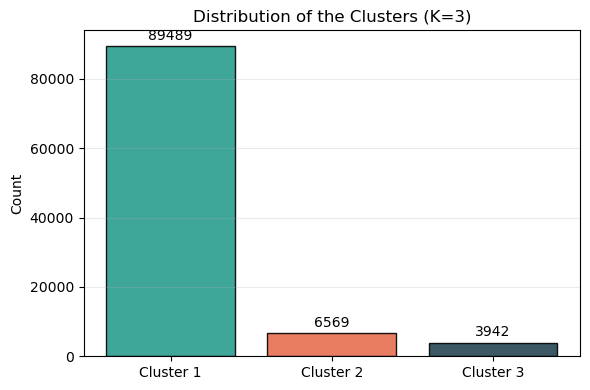

Silhouette (Euclidean, K=3): 0.472


In [38]:
# -------------------
# 2) K-Means++ (K=3) and distribution plot
# -------------------
K = 3
km = KMeans(n_clusters=K, init="k-means++", n_init=20, random_state=42)
labels = km.fit_predict(X_std)

# Distribution counts
counts = pd.Series(labels).value_counts().sort_index()
counts.index = [f"Cluster {i+1}" for i in counts.index]

# Distinct colors per cluster
colors = ["#2A9D8F", "#E76F51", "#264653"]  # teal, coral, navy (extend if needed)

plt.figure(figsize=(6,4))
bars = plt.bar(counts.index, counts.values, color=colors[:K], edgecolor="black", alpha=0.9)
for b in bars:
    plt.text(b.get_x()+b.get_width()/2, b.get_height()+0.01*counts.max(),
             f"{int(b.get_height())}", ha="center", va="bottom", fontsize=10)
plt.title("Distribution of the Clusters (K=3)")
plt.ylabel("Count")
plt.grid(axis="y", alpha=0.25)
plt.tight_layout()
plt.show()

# Optional: Silhouette (info only)
sil = silhouette_score(X_std, labels)
print(f"Silhouette (Euclidean, K=3): {sil:.3f}")


Top variables associated with diabetes (combined score):


,abs_pearson,mutual_info,abs_logreg_coef,avg_score
HbA1c_level,0.9550,1.0000,1.0000,0.9850
blood_glucose_level,1.0000,0.8668,0.5430,0.8033
age,0.6150,0.3218,0.4140,0.4503
bmi,0.5109,0.1812,0.2405,0.3109
hypertension,0.4715,0.1563,0.0852,0.2377
heart_disease,0.4093,0.0999,0.0624,0.1905


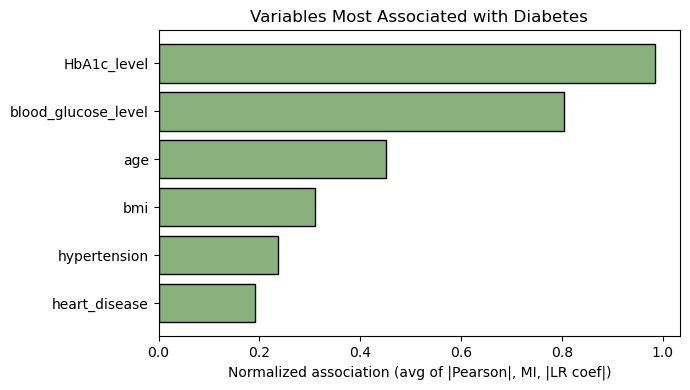


Cluster profiles (means in standardized space) for top variables:


,HbA1c_level,blood_glucose_level,age,bmi,hypertension,heart_disease
Cluster 1,5.49,136.60,39.36,26.97,0.00,0.0
Cluster 2,5.81,149.48,60.73,30.88,1.00,0.0
Cluster 3,5.88,152.14,67.82,29.33,0.23,1.0


In [41]:
# -------------------
# 3) Variables most associated with diabetes
# -------------------
if y_col is None:
    print("No binary diabetes column found — skipping association analysis.")
else:
    y = df[y_col].astype(int).values

    # Align X and y rows (drop rows with missing y)
    ok = ~pd.isna(y)
    X_mat = X_std[ok]
    y_vec = y[ok]

    # (a) |Pearson| (point-biserial) correlation
    corrs = []
    for j in range(X_mat.shape[1]):
        xj = X_mat[:, j]
        if np.std(xj) == 0 or np.std(y_vec) == 0:
            corrs.append(0.0)
        else:
            corrs.append(np.corrcoef(xj, y_vec)[0,1])
    corr_abs = pd.Series(np.abs(corrs), index=X_df.columns, name="abs_pearson")

    # (b) Mutual information (classification)
    mi = pd.Series(mutual_info_classif(X_mat, y_vec, random_state=42), index=X_df.columns, name="mutual_info")

    # (c) Standardized Logistic Regression coefficients (L2 to stabilize)
    lr = LogisticRegression(max_iter=2000, penalty="l2", solver="lbfgs", n_jobs=-1)
    lr.fit(X_mat, y_vec)
    coef_abs = pd.Series(np.abs(lr.coef_[0]), index=X_df.columns, name="abs_logreg_coef")

    # Combine: normalize each metric to 0..1, then average
    feat = pd.concat([corr_abs, mi, coef_abs], axis=1).fillna(0.0)
    for col in feat.columns:
        m = feat[col].max()
        if m > 0: feat[col] = feat[col] / m
    feat["avg_score"] = feat.mean(axis=1)
    top = feat.sort_values("avg_score", ascending=False).head(12)

    # Show table
    print("\nTop variables associated with diabetes (combined score):")
    display(top.round(4))

    # Bar plot
    plt.figure(figsize=(7,4))
    plt.barh(top.index[::-1], top["avg_score"][::-1], color="#8AB17D", edgecolor="black")
    plt.xlabel("Normalized association (avg of |Pearson|, MI, |LR coef|)")
    plt.title("Variables Most Associated with Diabetes")
    plt.tight_layout()
    plt.show()

    # Optional: per-cluster profile on those top variables (means)
    prof = pd.DataFrame(X_df.iloc[ok].values, columns=X_df.columns)
    prof["cluster"] = labels[ok]
    prof_means = prof.groupby("cluster")[top.index.tolist()].mean()
    prof_means.index = [f"Cluster {i+1}" for i in prof_means.index]
    print("\nCluster profiles (means in standardized space) for top variables:")
    display(prof_means.round(2))

C:\Users\Omistaja\AppData\Local\Temp\ipykernel_22672\4218395309.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Cluster", y="HbA1c_level", data=df_plot,


<Figure size 700x500 with 0 Axes>

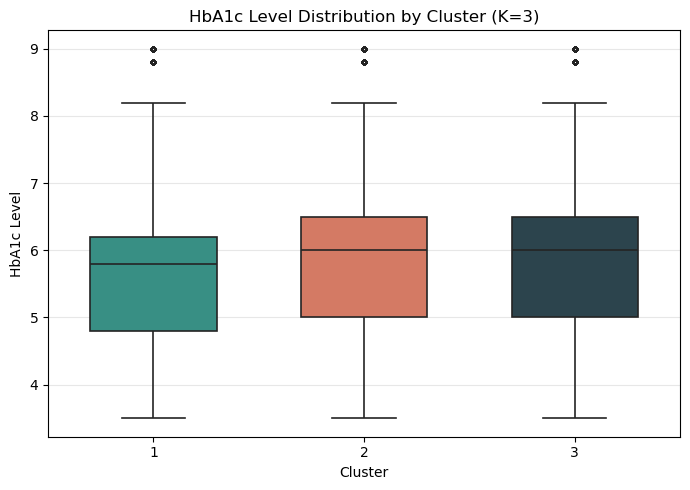

In [53]:
# ======================
# Box & Whisker Plot — HbA1c_level by Cluster (K=3)
# ======================
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Create DataFrame with HbA1c_level and cluster labels
df_plot = pd.DataFrame({
    "HbA1c_level": df["HbA1c_level"],  # use your dataset column name exactly
    "Cluster": labels
})

# Rename clusters to start at 1 for readability
df_plot["Cluster"] = df_plot["Cluster"] + 1

# Convert to string so Seaborn palette lookup works
df_plot["Cluster"] = df_plot["Cluster"].astype(str)
# Force order to be 1, 2, 3
cluster_order = ["1", "2", "3"]


# Set color palette — one color per cluster (string keys)
palette = {"1": "#2A9D8F", "2": "#E76F51", "3": "#264653"}

# Plot box & whiskers
plt.figure(figsize=(7, 5))
sns.boxplot(x="Cluster", y="HbA1c_level", data=df_plot,
            order = cluster_order, palette=palette, width=0.6, fliersize=3, linewidth=1.2)

# Style & labels
plt.title("HbA1c Level Distribution by Cluster (K=3)")
plt.xlabel("Cluster")
plt.ylabel("HbA1c Level")
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


C:\Users\Omistaja\AppData\Local\Temp\ipykernel_22672\3666646254.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Cluster", y="Blood_Glucose_Level", data=df_glucose,


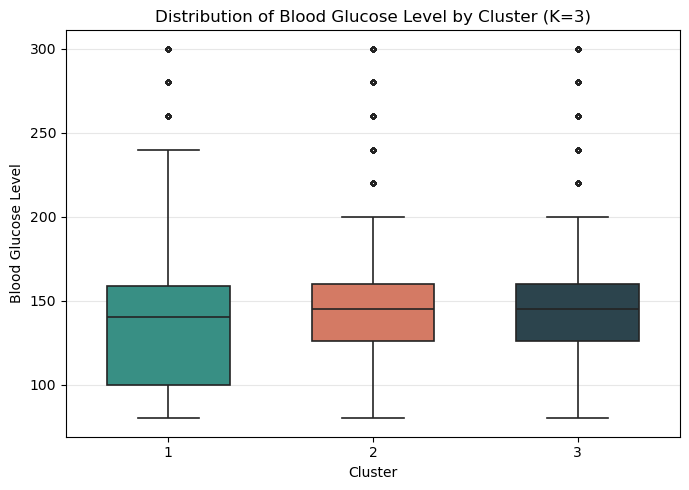

In [50]:
# ======================
# Box & Whisker Plot — Blood Glucose Level by Cluster (K=3, ordered)
# ======================
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Create DataFrame with Blood Glucose Level and cluster labels
df_glucose = pd.DataFrame({
    "Blood_Glucose_Level": df["blood_glucose_level"],  # ensure correct column name
    "Cluster": labels
})

# Rename clusters to start at 1 for readability
df_glucose["Cluster"] = df_glucose["Cluster"] + 1
df_glucose["Cluster"] = df_glucose["Cluster"].astype(str)

# Define a consistent palette for clusters
palette = {"1": "#2A9D8F", "2": "#E76F51", "3": "#264653"}

# Force order to be 1, 2, 3
cluster_order = ["1", "2", "3"]

# Plot box & whiskers
plt.figure(figsize=(7, 5))
sns.boxplot(x="Cluster", y="Blood_Glucose_Level", data=df_glucose,
            order=cluster_order, palette=palette,
            width=0.6, fliersize=3, linewidth=1.2)

# Style and labels
plt.title("Distribution of Blood Glucose Level by Cluster (K=3)")
plt.xlabel("Cluster")
plt.ylabel("Blood Glucose Level")
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

C:\Users\Omistaja\AppData\Local\Temp\ipykernel_22672\1764769540.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


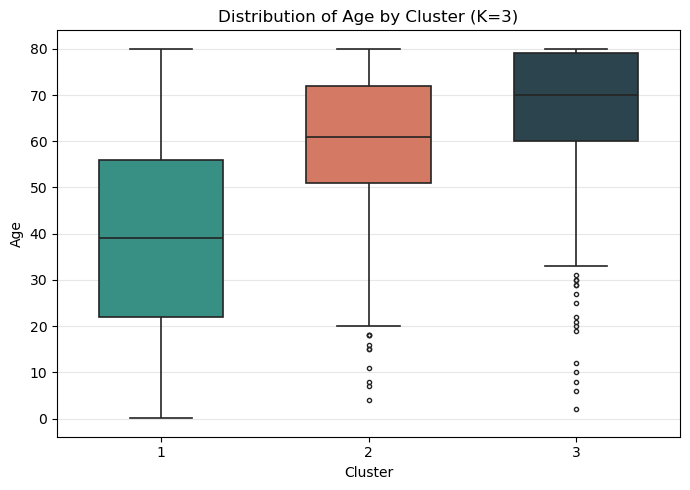

In [54]:
# Create DataFrame with Age and cluster labels
df_age = pd.DataFrame({
    "Age": df["age"],  # ensure column name matches your dataset
    "Cluster": labels
})

# Rename clusters to start at 1 for readability
df_age["Cluster"] = df_age["Cluster"] + 1
df_age["Cluster"] = df_age["Cluster"].astype(str)

# Define color palette for clusters
palette = {"1": "#2A9D8F", "2": "#E76F51", "3": "#264653"}  # teal, coral, navy
cluster_order = ["1", "2", "3"]

# Create box plot
plt.figure(figsize=(7, 5))
sns.boxplot(
    x="Cluster", 
    y="Age", 
    data=df_age,
    order=cluster_order,
    palette=palette,
    width=0.6,
    fliersize=3,
    linewidth=1.2
)

# Labels and aesthetics
plt.title("Distribution of Age by Cluster (K=3)")
plt.xlabel("Cluster")
plt.ylabel("Age")
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Experimental Analysis on World Bank Dataset

C:\Users\Omistaja\anaconda3\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


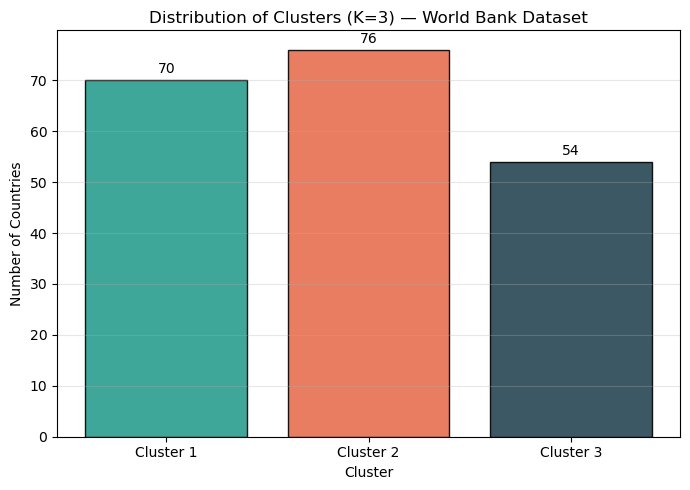

Silhouette Score (Euclidean, K=3): 0.124


In [55]:
# --- Load dataset ---
df = pd.read_csv("world_bank_dataset.csv")

# --- Feature selection (drop non-numeric columns) ---
X = df.select_dtypes(include=['number']).dropna()

# --- Standardize ---
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# --- K-Means clustering (K=3) ---
K = 3
km = KMeans(n_clusters=K, init="k-means++", n_init=20, random_state=42)
labels = km.fit_predict(X_std)

# --- Compute distribution ---
counts = pd.Series(labels).value_counts().sort_index()
counts.index = [f"Cluster {i+1}" for i in counts.index]

# --- Colour palette (teal, coral, navy) ---
colors = ["#2A9D8F", "#E76F51", "#264653"]

# --- Plot bar chart ---
plt.figure(figsize=(7,5))
bars = plt.bar(counts.index, counts.values, color=colors, edgecolor="black", alpha=0.9)

# Add labels above bars
for b in bars:
    plt.text(b.get_x() + b.get_width()/2,
             b.get_height() + 0.01*counts.max(),
             f"{int(b.get_height())}",
             ha="center", va="bottom", fontsize=10)

plt.title("Distribution of Clusters (K=3) — World Bank Dataset")
plt.ylabel("Number of Countries")
plt.xlabel("Cluster")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

# --- Optional: Silhouette score ---
from sklearn.metrics import silhouette_score
sil = silhouette_score(X_std, labels)
print(f"Silhouette Score (Euclidean, K={K}): {sil:.3f}")

C:\Users\Omistaja\anaconda3\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


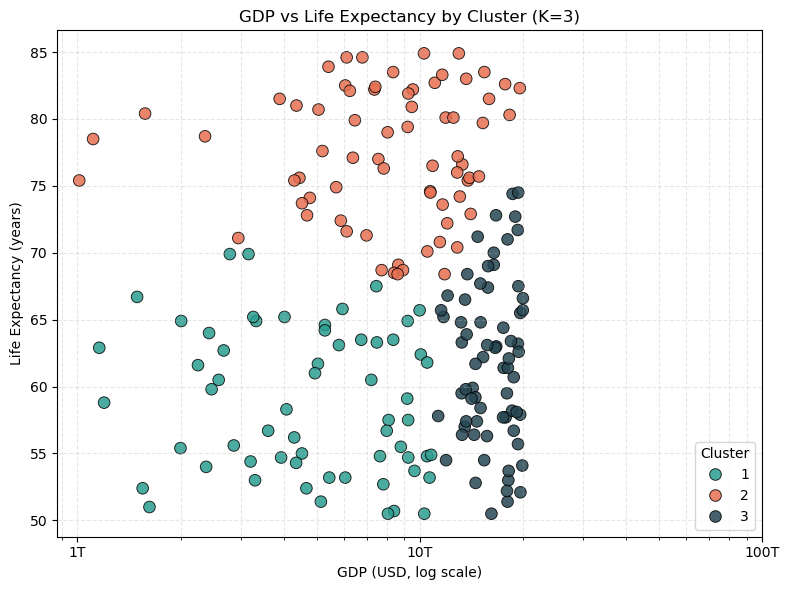

In [60]:

# --- Select & clean ---
cols = ["GDP (USD)", "Life Expectancy"]
df_plot = df[cols].dropna().copy()

# --- Cluster in standardized space ---
scaler = StandardScaler()
X_std = scaler.fit_transform(df_plot)

K = 3
km = KMeans(n_clusters=K, init="k-means++", n_init=20, random_state=42)
labels = km.fit_predict(X_std)
df_plot["Cluster"] = labels + 1  # 1..K for readability

# --- Colors for clusters ---
palette = {1: "#2A9D8F", 2: "#E76F51", 3: "#264653"}

# --- Scatterplot ---
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df_plot,
    x="GDP (USD)",
    y="Life Expectancy",
    hue="Cluster",
    palette=palette,
    s=70, alpha=0.85, edgecolor="black"
)

# --- Log x-axis with regular, readable ticks (billions/trillions) ---
plt.xscale("log")

gdp_min = df_plot["GDP (USD)"].min()
gdp_max = df_plot["GDP (USD)"].max()
# powers-of-ten between min and max
exp_lo = int(np.floor(np.log10(gdp_min)))
exp_hi = int(np.ceil(np.log10(gdp_max)))
major_ticks = [10**e for e in range(exp_lo, exp_hi + 1)]

def fmt_usd(x):
    if x >= 1e12:
        return f"{int(x/1e12)}T"
    elif x >= 1e9:
        return f"{int(x/1e9)}B"
    else:
        return f"{int(x):,}"

plt.xticks(major_ticks, [fmt_usd(t) for t in major_ticks])

# --- Aesthetics ---
plt.title("GDP vs Life Expectancy by Cluster (K=3)")
plt.xlabel("GDP (USD, log scale)")
plt.ylabel("Life Expectancy (years)")
plt.legend(title="Cluster", loc="lower right", frameon=True)
plt.grid(alpha=0.3, which="both", linestyle="--")
plt.tight_layout()
plt.show()


# BodyFat Prediction Dataset

In [71]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Load
df = pd.read_csv("bodyfat.csv")  # adjust path if needed

# Numeric features only, drop constants
X_df = df.select_dtypes(include=[np.number]).copy()
X_df = X_df.loc[:, X_df.nunique(dropna=False) > 1]

# Impute + standardize
imp = SimpleImputer(strategy="median")
X_imp = imp.fit_transform(X_df.values)

scaler = StandardScaler()
X_std = scaler.fit_transform(X_imp)

# K-Means++ (K=2)
K = 2
km = KMeans(n_clusters=K, init="k-means++", n_init=20, random_state=42)
labels = km.fit_predict(X_std)

# Inertia
print(f"Inertia (sum of squared distances), K={K}: {km.inertia_:.6f}")

# Cluster centers in original feature units
centers_std = km.cluster_centers_
centers_orig = scaler.inverse_transform(centers_std)  # <-- only reverse scaling
centers_df = pd.DataFrame(
    centers_orig, columns=X_df.columns, index=[f"Cluster {i+1}" for i in range(K)]
)

print("\nCluster Centers (original units):")
display(centers_df)

# Cluster sizes
sizes = pd.Series(labels).value_counts().sort_index()
sizes.index = [f"Cluster {i+1}" for i in sizes.index]
print("\nCluster sizes:")
display(sizes)

Inertia (sum of squared distances), K=2: 2362.855933

Cluster Centers (original units):


C:\Users\Omistaja\anaconda3\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


,Density,BodyFat,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist
Cluster 1,1.064806,14.972483,44.295302,160.480872,69.672819,36.664430,95.696644,85.869128,95.765772,56.484564,37.252349,22.382550,30.558389,27.694631,17.774497
Cluster 2,1.042218,25.195146,45.737864,205.604854,70.837379,39.912621,108.241748,102.229126,105.892233,63.632039,40.526214,24.143689,34.754369,30.066019,18.888350



Cluster sizes:


Cluster 1    149
Cluster 2    103
Name: count, dtype: int64

In [74]:
# Assuming centers_df is your existing DataFrame with cluster centers
centers_long = centers_df.reset_index().melt(
    id_vars='index',              # cluster labels column
    var_name='Feature',           # name for variable column
    value_name='Value'            # name for value column
).rename(columns={'index': 'Cluster'})

# Display melted (long-form) data
display(centers_long.head(25))

,Cluster,Feature,Value
0,Cluster 1,Density,1.064806
1,Cluster 2,Density,1.042218
2,Cluster 1,BodyFat,14.972483
3,Cluster 2,BodyFat,25.195146
4,Cluster 1,Age,44.295302
5,Cluster 2,Age,45.737864
6,Cluster 1,Weight,160.480872
7,Cluster 2,Weight,205.604854
8,Cluster 1,Height,69.672819
9,Cluster 2,Height,70.837379


In [75]:
# Rank features by absolute and percent differences between clusters
c1 = centers_df.loc["Cluster 1"]
c2 = centers_df.loc["Cluster 2"]

delta = (c2 - c1).rename("abs_diff")
pct   = ((c2 - c1) / c1 * 100).rename("pct_diff")

sep = pd.concat([c1.rename("Cluster 1"),
                 c2.rename("Cluster 2"),
                 delta, pct], axis=1).sort_values("abs_diff", ascending=False)

display(sep.round(2).head(12))

,Cluster 1,Cluster 2,abs_diff,pct_diff
Weight,160.48,205.60,45.12,28.12
Abdomen,85.87,102.23,16.36,19.05
Chest,95.70,108.24,12.55,13.11
BodyFat,14.97,25.20,10.22,68.28
Hip,95.77,105.89,10.13,10.57
Thigh,56.48,63.63,7.15,12.65
Biceps,30.56,34.75,4.20,13.73
Knee,37.25,40.53,3.27,8.79
Neck,36.66,39.91,3.25,8.86
Forearm,27.69,30.07,2.37,8.56


C:\Users\Omistaja\AppData\Local\Temp\ipykernel_22672\2067702778.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\Omistaja\AppData\Local\Temp\ipykernel_22672\2067702778.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\Omistaja\AppData\Local\Temp\ipykernel_22672\2067702778.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


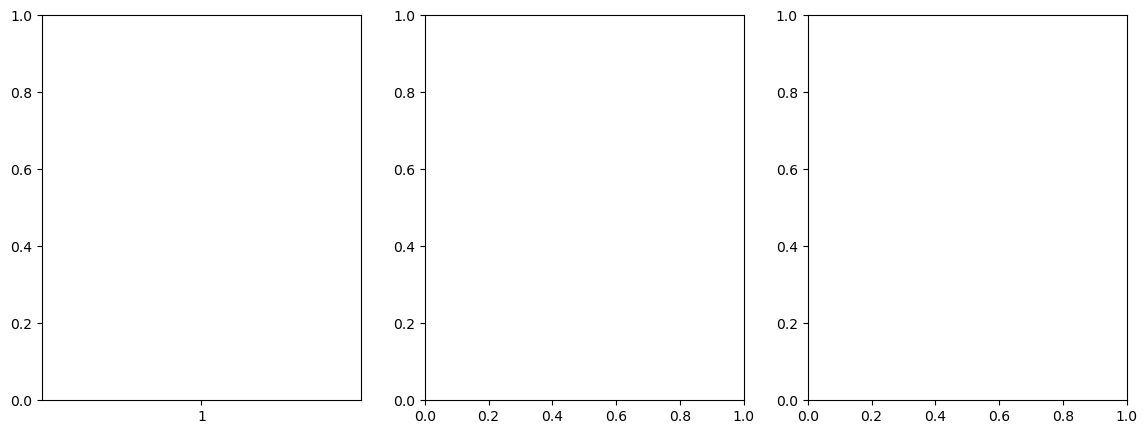

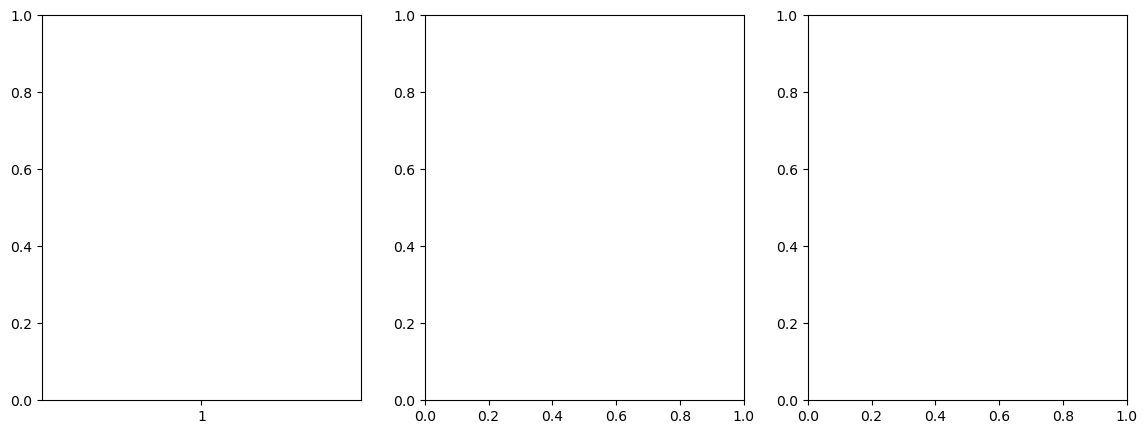

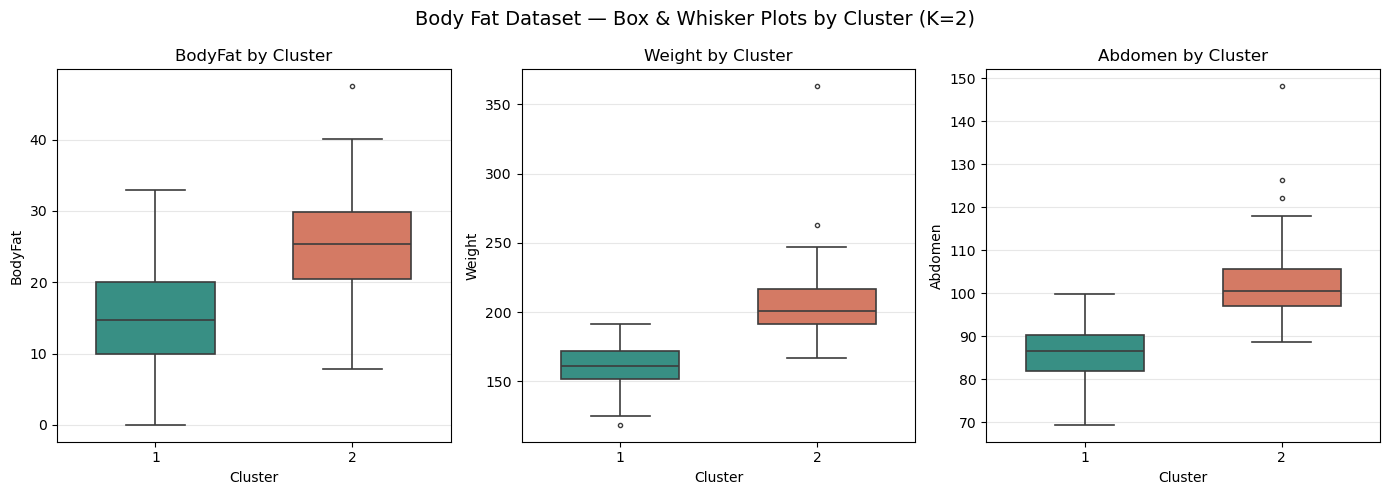

In [78]:
# ======================
# Box & Whisker Plots — BodyFat, Weight, Abdomen by Cluster (K=2, fixed palette mapping)
# ======================
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Build plotting frame (assumes X_df and labels from your KMeans step)
df_box = X_df.copy()
df_box["Cluster"] = (labels + 1).astype(str)  # <-- make clusters "1","2" so palette keys match

features = ["BodyFat", "Weight", "Abdomen"]
palette = {"1": "#2A9D8F", "2": "#E76F51"}   # teal for Cluster 1, coral for Cluster 2
order = ["1", "2"]                           # enforce ascending cluster order

fig, axes = plt.subplots(1, 3, figsize=(14, 5), sharey=False)

for ax, feat in zip(axes, features):
    sns.boxplot(
        data=df_box, x="Cluster", y=feat,
        order=order, palette=palette,
        width=0.6, fliersize=3, linewidth=1.2, ax=ax
    )
    ax.set_title(f"{feat} by Cluster")
    ax.set_xlabel("Cluster")
    ax.set_ylabel(feat)
    ax.grid(axis="y", alpha=0.3)

plt.suptitle("Body Fat Dataset — Box & Whisker Plots by Cluster (K=2)", fontsize=14)
plt.tight_layout()
plt.show()

C:\Users\Omistaja\AppData\Local\Temp\ipykernel_22672\1772695726.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\Omistaja\AppData\Local\Temp\ipykernel_22672\1772695726.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\Omistaja\AppData\Local\Temp\ipykernel_22672\1772695726.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


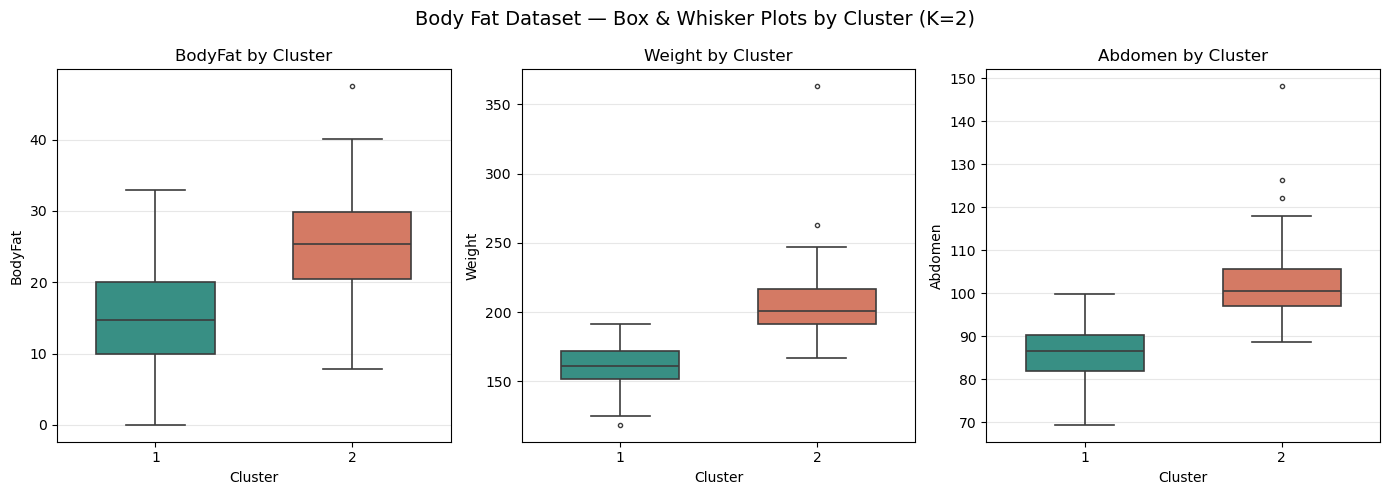

In [79]:
# Build plotting frame (assumes X_df and labels from your KMeans step)
df_box = X_df.copy()
df_box["Cluster"] = (labels + 1).astype(str)  # <-- make clusters "1","2" so palette keys match

features = ["BodyFat", "Weight", "Abdomen"]
palette = {"1": "#2A9D8F", "2": "#E76F51"}   # teal for Cluster 1, coral for Cluster 2
order = ["1", "2"]                           # enforce ascending cluster order

fig, axes = plt.subplots(1, 3, figsize=(14, 5), sharey=False)

for ax, feat in zip(axes, features):
    sns.boxplot(
        data=df_box, x="Cluster", y=feat,
        order=order, palette=palette,
        width=0.6, fliersize=3, linewidth=1.2, ax=ax
    )
    ax.set_title(f"{feat} by Cluster")
    ax.set_xlabel("Cluster")
    ax.set_ylabel(feat)
    ax.grid(axis="y", alpha=0.3)

plt.suptitle("Body Fat Dataset — Box & Whisker Plots by Cluster (K=2)", fontsize=14)
plt.tight_layout()
plt.show()

C:\Users\Omistaja\anaconda3\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Omistaja\anaconda3\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Omistaja\anaconda3\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Omistaja\anaconda3\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

,k,inertia,silhouette,davies_bouldin,calinski_harabasz
0,2,2362.856,0.327,1.169,149.940
1,3,2012.819,0.215,1.367,109.306
2,4,1837.935,0.174,1.680,87.350
3,5,1693.470,0.166,1.437,76.082
4,6,1556.570,0.191,1.269,70.278
5,7,1461.346,0.162,1.468,64.788
6,8,1348.833,0.147,1.279,62.827
7,9,1279.691,0.145,1.416,59.348
8,10,1203.774,0.141,1.364,57.546


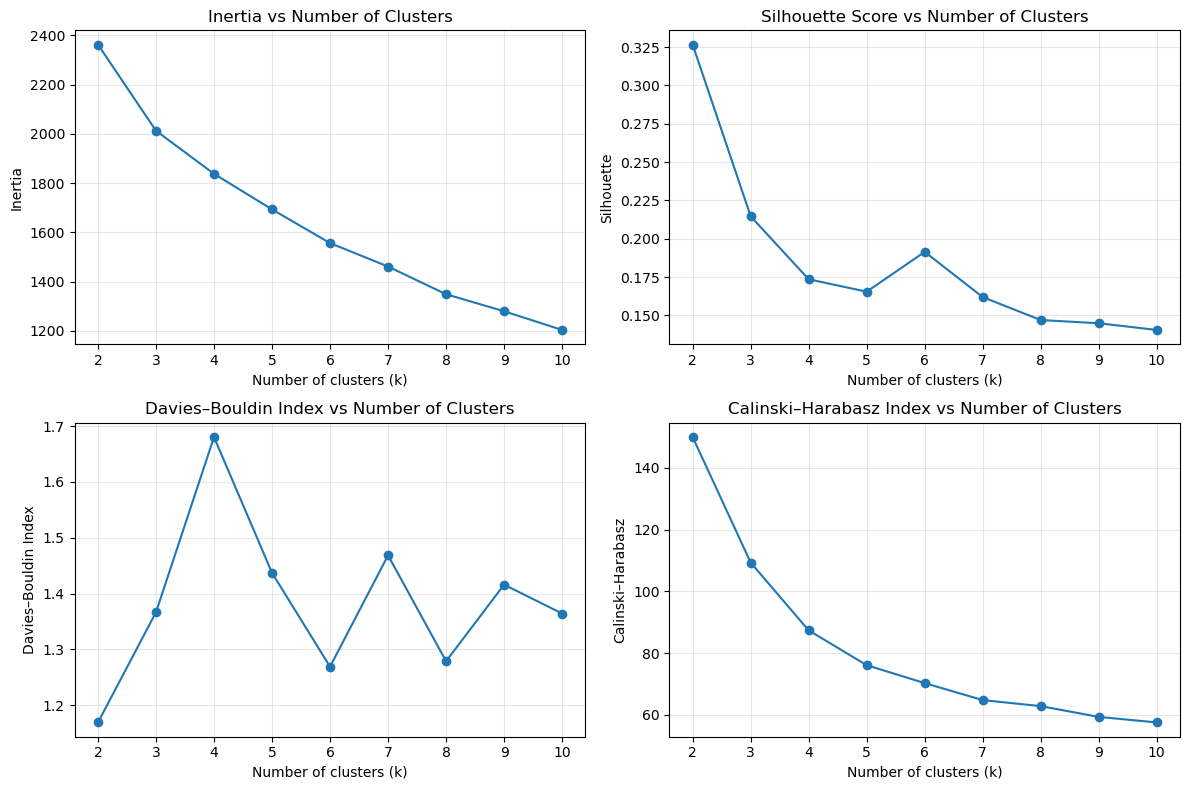

Best k by Silhouette (↑): k=2
Best k by Davies–Bouldin (↓): k=2
Best k by Calinski–Harabasz (↑): k=2
Use the inertia plot's 'elbow' as a sanity check.


In [80]:
# ======================
# K-Scan: Inertia, Silhouette, Davies–Bouldin, Calinski–Harabasz
# ======================
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# ---- Config ----
DATA_CSV = "bodyfat.csv"        # <- change to your file if needed
K_MIN, K_MAX = 2, 10            # range of K to scan (inclusive)

# ---- Load & preprocess (numeric only, impute, standardize) ----
df = pd.read_csv(DATA_CSV)
X_df = df.select_dtypes(include=[np.number]).copy()
X_df = X_df.loc[:, X_df.nunique(dropna=False) > 1]  # drop near-constant columns

imp = SimpleImputer(strategy="median")
X_imp = imp.fit_transform(X_df.values)

scaler = StandardScaler()
X_std = scaler.fit_transform(X_imp)

# ---- Scan K ----
rows = []
for k in range(K_MIN, K_MAX + 1):
    km = KMeans(n_clusters=k, init="k-means++", n_init=20, random_state=42)
    labels = km.fit_predict(X_std)

    inertia = km.inertia_
    sil = silhouette_score(X_std, labels)               # higher is better
    db = davies_bouldin_score(X_std, labels)            # lower is better
    ch = calinski_harabasz_score(X_std, labels)         # higher is better

    rows.append({"k": k, "inertia": inertia, "silhouette": sil, "davies_bouldin": db, "calinski_harabasz": ch})

results = pd.DataFrame(rows)
display(results.round(3))

# ---- Plot 2x2 metrics vs K ----
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.ravel()

# Inertia (Elbow)
axes[0].plot(results["k"], results["inertia"], marker="o")
axes[0].set_title("Inertia vs Number of Clusters")
axes[0].set_xlabel("Number of clusters (k)")
axes[0].set_ylabel("Inertia")
axes[0].grid(alpha=0.3)

# Silhouette
axes[1].plot(results["k"], results["silhouette"], marker="o")
axes[1].set_title("Silhouette Score vs Number of Clusters")
axes[1].set_xlabel("Number of clusters (k)")
axes[1].set_ylabel("Silhouette")
axes[1].grid(alpha=0.3)

# Davies–Bouldin (lower is better)
axes[2].plot(results["k"], results["davies_bouldin"], marker="o")
axes[2].set_title("Davies–Bouldin Index vs Number of Clusters")
axes[2].set_xlabel("Number of clusters (k)")
axes[2].set_ylabel("Davies–Bouldin Index")
axes[2].grid(alpha=0.3)

# Calinski–Harabasz
axes[3].plot(results["k"], results["calinski_harabasz"], marker="o")
axes[3].set_title("Calinski–Harabasz Index vs Number of Clusters")
axes[3].set_xlabel("Number of clusters (k)")
axes[3].set_ylabel("Calinski–Harabasz")
axes[3].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# ---- Quick suggestions (best per metric) ----
k_sil_best = results.loc[results["silhouette"].idxmax(), "k"]
k_db_best  = results.loc[results["davies_bouldin"].idxmin(), "k"]
k_ch_best  = results.loc[results["calinski_harabasz"].idxmax(), "k"]

print(f"Best k by Silhouette (↑): k={k_sil_best}")
print(f"Best k by Davies–Bouldin (↓): k={k_db_best}")
print(f"Best k by Calinski–Harabasz (↑): k={k_ch_best}")
print("Use the inertia plot's 'elbow' as a sanity check.")